<a href="https://colab.research.google.com/github/alezakuskin/Stark_ML/blob/Temperature-tuning/Main_body.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# StarkML: Machine Learning-based Tool for Predicting Stark Parameters of Atomic Emission Lines

# Imports

In [1]:
#!pip install pytorch-tabnet
#!git clone -b Ions https://github.com/alezakuskin/Stark_ML

In [1]:
RunInColab = 'google.colab' in str(get_ipython())
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

#Installing missing packages
!pip install optuna
!pip install xgboost
!pip install lightgbm
!pip install roman

#Imports
import os
import stat
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import time
import importlib
import json
import torch
import lightgbm
#torch.autograd.set_detect_anomaly(False)
#torch.set_default_tensor_type(torch.DoubleTensor)
#torch.set_default_dtype(torch.float64)

#Importing sklearn models and metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn.preprocessing import StandardScaler

#Importing TabNet Regressor model    
#from pytorch_tabnet.tab_model import  TabNetRegressor

np.random.seed(777)

import pytorch_tabnet
'''os.environ['tabnet'] = pytorch_tabnet.__path__.__dict__['_path'][0]
os.environ['patchfile'] = os.path.abspath(os.path.join('Stark_ML', 'float64.patch'))
if os.name == 'nt':
    !cd /d %tabnet% & patch < "%patchfile%"
else:
    !cd $tabnet && patch -f < $patchfile
importlib.reload(pytorch_tabnet)'''

if RunInColab:
    from google.colab import output
    def clear_output():
        output.clear()
else:
    from IPython import display
    def clear_output():
        display.clear_output()

clear_output()

In [2]:
#Download and import all utilities and models
'''if os.path.isdir('Stark_ML'):
    import Stark_ML
    def remove_readonly(func, path, _):
            os.chmod(path, stat.S_IWRITE)
            func(path)
    shutil.rmtree(Stark_ML.__path__.__dict__['_path'][0], onerror = remove_readonly)

!git clone -b Ions https://github.com/alezakuskin/Stark_ML'''

import Stark_ML
import Stark_ML.utils.optuning
import Stark_ML.models.base_models
import Stark_ML.utils.metrics
import Stark_ML.utils.terms
import Stark_ML.utils.testset
import Stark_ML.utils.plotting
import Stark_ML.models.tabnet

importlib.reload(Stark_ML.models.base_models)
importlib.reload(Stark_ML.utils.optuning)
importlib.reload(Stark_ML.utils.metrics)
importlib.reload(Stark_ML.utils.plotting)
importlib.reload(Stark_ML.models.tabnet)

from Stark_ML.models.base_models import *
from Stark_ML.utils.optuning import *
from Stark_ML.utils.metrics import *
from Stark_ML.utils.terms import *
from Stark_ML.utils.testset import *
from Stark_ML.utils.plotting import *
from Stark_ML.models.tabnet import *
from Stark_ML.utils import *
from pytorch_tabnet.tab_model import  TabNetRegressor
clear_output()

# Data preprocessing

In [214]:
#Import data for training and testing
data_a = pd.read_excel(Stark_ML.__path__.__dict__['_path'][0] + '/Source_files/Stark_data.xlsx',
                     sheet_name='Experimental',
                     usecols='A:BF'
                   )
#Replace term symbols with quantum numbers
data_a['Term'] = term_to_number(data_a['Term'])
data_a['Term.1'] = term_to_number(data_a['Term.1'])

#Replace accuracy symbols with uncetrainty in %
data_a['w error (%)'] = uncertainty_to_number(data_a[data_a['w error (%)'].notna()]['w error (%)'])
data_a['d error (%)'] = uncertainty_to_number(data_a[data_a['d error (%)'].notna()]['d error (%)'])

In [215]:
#Import ions data for training and testing
data_i = pd.read_excel(Stark_ML.__path__.__dict__['_path'][0] + '/Source_files/Stark_data.xlsx',
                     sheet_name='Ions',
                     usecols='A:BQ'
                   )
#Replace term symbols with quantum numbers
data_i['Term'] = term_to_number(data_i['Term'])
data_i['Term.1'] = term_to_number(data_i['Term.1'])

#Replace accuracy symbols with uncetrainty in %
data_i['w error (%)'] = uncertainty_to_number(data_i[data_i['w error (%)'].notna()]['w error (%)'])
data_i['d error (%)'] = uncertainty_to_number(data_i[data_i['d error (%)'].notna()]['d error (%)'])

#Drop entries with levels' data unavailable
data_i = data_i[data_i['J'].notna()]
data_i = data_i[data_i['J.1'].notna()]

In [216]:
#Making sure that atoms and ions datasets have the same set of columns
for i, name in enumerate(data_i.columns):
    if name != data_a.columns[i]:
        if name in data_a.columns:
            print(f'renaming {name}')
            data_a = data_a.rename(columns = {name: name+'.1'})
        data_a.insert(i, data_i.columns[i], 0)
        print(data_i.columns[i])

Charge
5f
5g
renaming 6d
6d
renaming 7p
7p
5f.1
5g.1
6f
6g
6h
11s


In [217]:
#Merging atoms and ions together
data = pd.concat([data_a, data_i], axis = 0, ignore_index = True)

#Incerting "gap to ionization energy" feature
data.insert(data.columns.get_loc('E upper')+1, 'Gap to ion', 0)
data['Gap to ion'] = gap_to_ion(data, 'E upper')

In [218]:
#Step 1.
#Exclude elements for testing
#Defining elements to exclude from training set
elements_to_exclude = ['S', 'Mg', 'Mn']

In [219]:
#Step 2.
#Creating data, targets and labels for the process of width prediction
data_width = data[data['w (A)'].isna() == False]
data_width_elements = data_width.loc[data_width['Element'].isin(elements_to_exclude)]
data_width = data_width.drop(data_width_elements.index)
data_width = data_width.sort_values(by=['Z number'])

#Separate targets from data
target_width = data_width['w (A)']
target_width_elements = data_width_elements['w (A)']

#Separate labels from data
label_width = data_width.loc[:, ['Element', 'Wavelength']]
label_width_elements = data_width_elements.loc[:, ['Element', 'Wavelength']]

#Remove width and shift values from data
data_width = data_width.drop(columns = ['d (A)', 'w (A)'])
data_width_elements = data_width_elements.drop(columns = ['d (A)', 'w (A)'])

#Remove uncertainty from data
data_width = data_width.drop(columns = ['w error (%)', 'd error (%)'])
data_width_elements = data_width_elements.drop(columns = ['w error (%)', 'd error (%)'])

In [220]:
#Step 3.
#Split into train and test by quartiles
#Q1
data_test_q1, target_test_q1 = test_selection(data_width,
                                              target_width,
                                              p = 0.137,
                                              low_limit = 'min',
                                              up_limit = 25,
                                              random_state = 7)
#Q2
data_test_q2, target_test_q2 = test_selection(data_width,
                                              target_width,
                                              p = 0.137,
                                              low_limit = 25,
                                              up_limit = 50,
                                              random_state = 7)
#Q3
data_test_q3, target_test_q3 = test_selection(data_width,
                                              target_width,
                                              p = 0.137,
                                              low_limit = 50,
                                              up_limit = 75,
                                              random_state = 7)
#Q4
target_test_q4 = pd.Series()
while len(target_test_q4[target_test_q4 > 150]) < 1 or len(target_test_q4[(target_test_q4 > 70) & (target_test_q4 < 150)]) < 1:
    data_test_q4, target_test_q4 = test_selection(data_width,
                                                target_width,
                                                p = 0.137,
                                                low_limit = 75,
                                                random_state = None)
#manually selected and fixed random state that gives the closest train and test distributios  
data_test_q4, target_test_q4 = test_selection(data_width,
                                                target_width,
                                                p = 0.137,
                                                low_limit = 75,
                                                random_state = 3)

#Combining quartiles into full test dataset
data_width_test, target_width_test = pd.concat([data_test_q1, data_test_q2]), pd.concat([target_test_q1, target_test_q2])
data_width_test, target_width_test = pd.concat([data_width_test, data_test_q3]), pd.concat([target_width_test, target_test_q3])
data_width_test, target_width_test = pd.concat([data_width_test, data_test_q4]), pd.concat([target_width_test, target_test_q4])

#Remove test entries from data -> get train set
data_width_train, target_width_train = data_width.drop(data_width_test.index), target_width.drop(target_width_test.index)

## -- *OPTIONAL*-- Atoms + ions data visual description

In [11]:
data_width_stats = target_width.describe()
print(data_width_stats)

count    5647.000000
mean        1.300846
std         5.433344
min         0.001500
25%         0.144182
50%         0.340000
75%         0.929138
max       180.500000
Name: w (A), dtype: float64


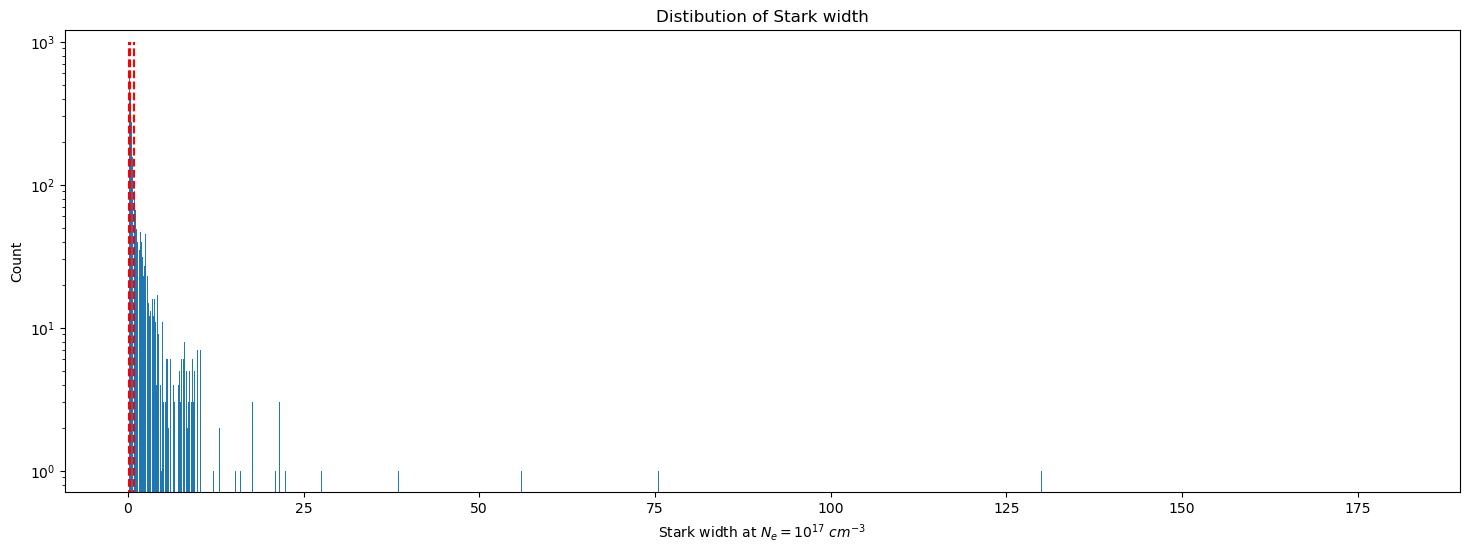

In [157]:
fig, ax = plt.subplots(figsize = (18, 6))
n, bins, patches = plt.hist(target_width, bins='auto', log=True, rwidth = 0.8)
ax.vlines(x = data_width_stats['25%'], ymin = 0, ymax = 1000, ls='--', colors='r')
ax.vlines(x = data_width_stats['50%'], ymin = 0, ymax = 1000, ls='--', colors='r')
ax.vlines(x = data_width_stats['75%'], ymin = 0, ymax = 1000, ls='--', colors='r')

ax.set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
ax.set_ylabel('Count')
ax.set_title('Distibution of Stark width')

plt.show()

#plt.savefig('Width distribution.png', dpi = 300)

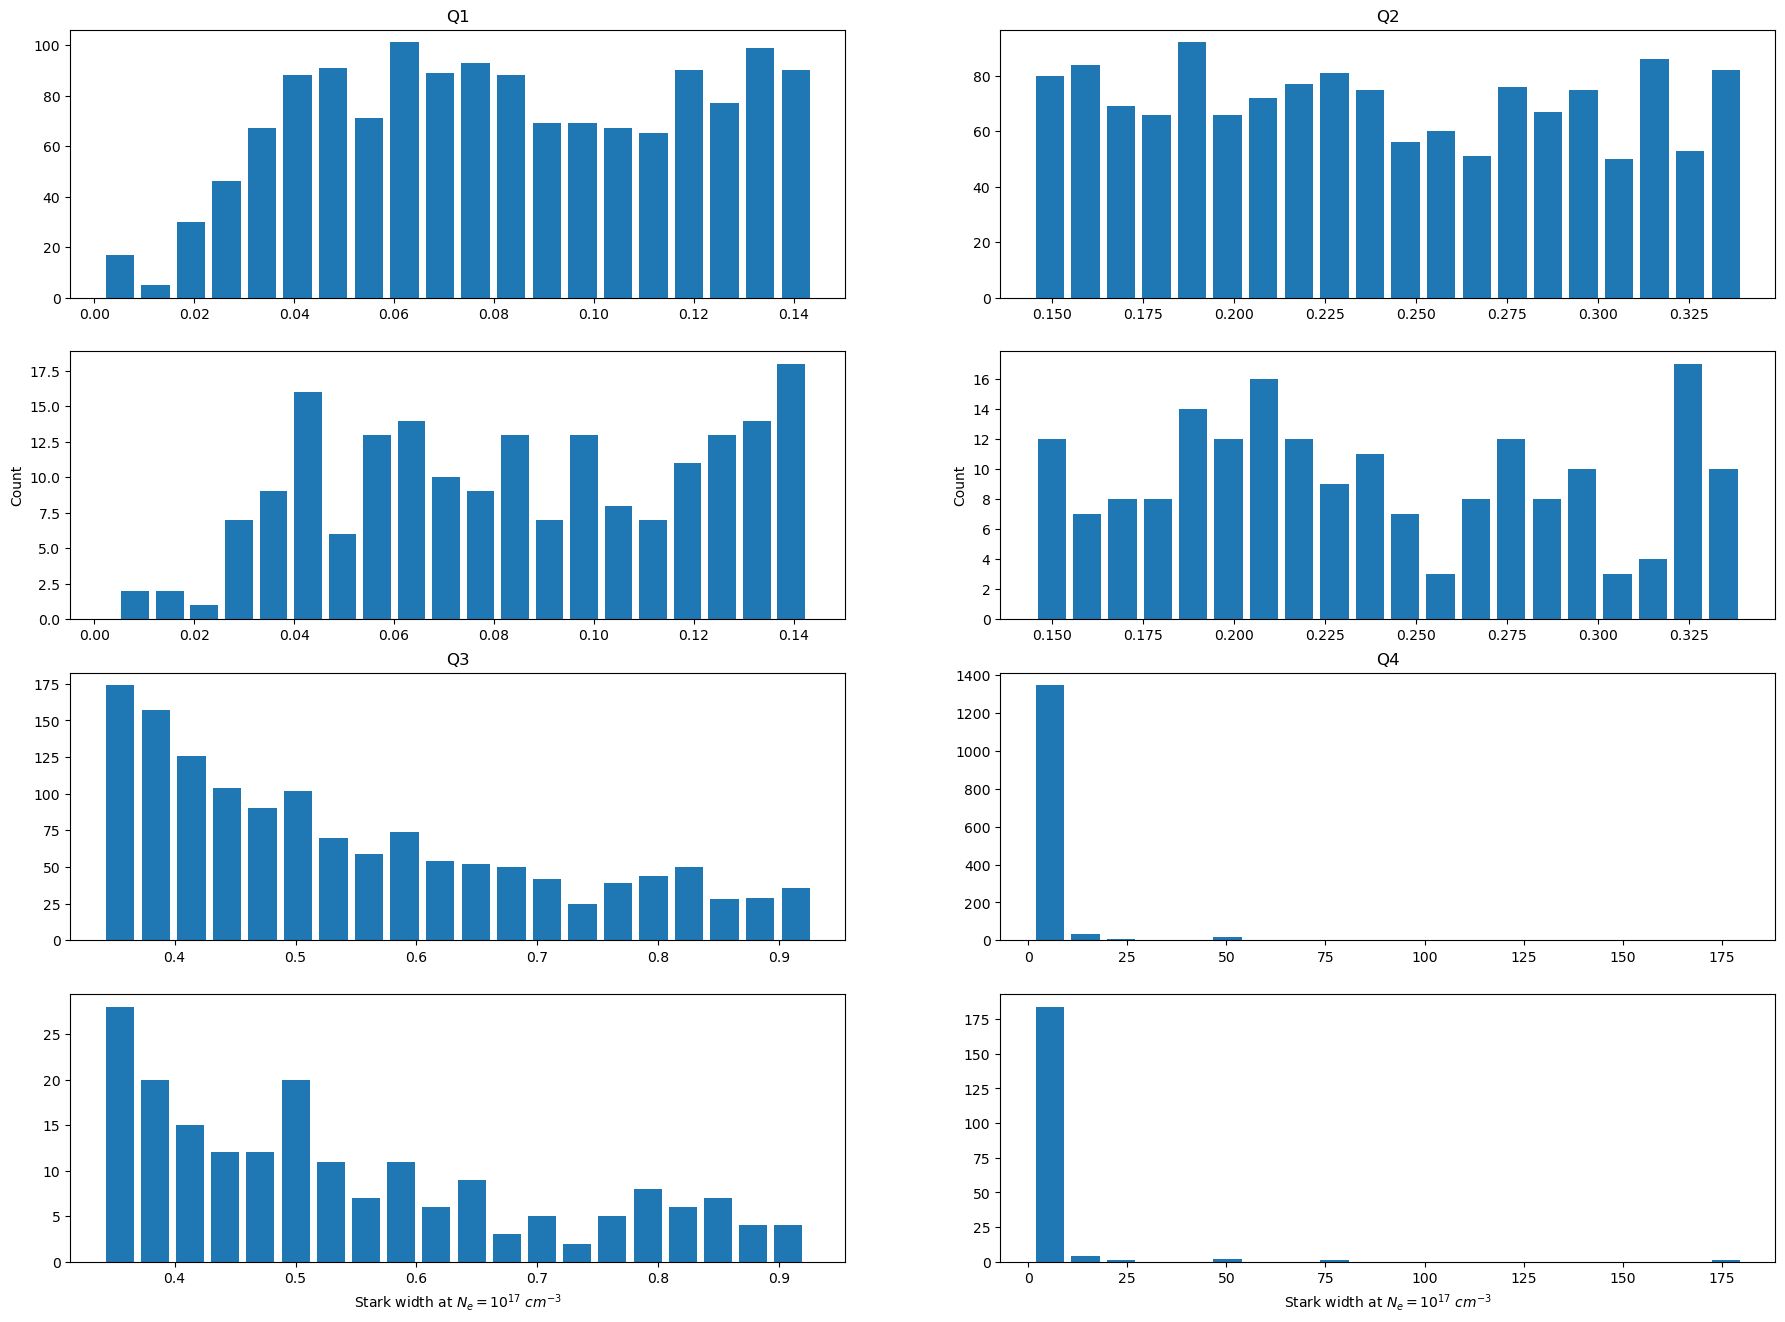

In [12]:
#Plotting train-test distributions
fig, axs = plt.subplots(4, 2, figsize = (22, 16), sharex = False)

axs[0, 0].hist(target_width[target_width <= data_width_stats['25%']], bins=20, log=False, rwidth = 0.8)
axs[1, 0].hist(target_test_q1, bins = 20, rwidth = 0.8)

axs[0, 1].hist(target_width[(target_width > data_width_stats['25%']) & (target_width <= data_width_stats['50%'])],
                            bins=20, log=False, rwidth = 0.8)
axs[1, 1].hist(target_test_q2, bins = 20, rwidth = 0.8)

axs[2, 0].hist(target_width[(target_width > data_width_stats['50%']) & (target_width <= data_width_stats['75%'])],
                            bins=20, log=False, rwidth = 0.8)
axs[3, 0].hist(target_test_q3, bins = 20, rwidth = 0.8)

axs[2, 1].hist(target_width[target_width > data_width_stats['75%']],
                            bins=20, log=False, rwidth = 0.8)
axs[3, 1].hist(target_test_q4, bins = 20, rwidth = 0.8)

axs[1, 0].sharex(axs[0, 0])
axs[3, 0].sharex(axs[2, 0])
axs[1, 1].sharex(axs[0, 1])
axs[3, 1].sharex(axs[2, 1])

axs[0, 0].set_title('Q1')
axs[2, 0].set_title('Q3')
axs[0, 1].set_title('Q2')
axs[2, 1].set_title('Q4')
axs[1, 0].set_ylabel('Count')
axs[1, 1].set_ylabel('Count')
axs[3, 0].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
axs[3, 1].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
plt.show()

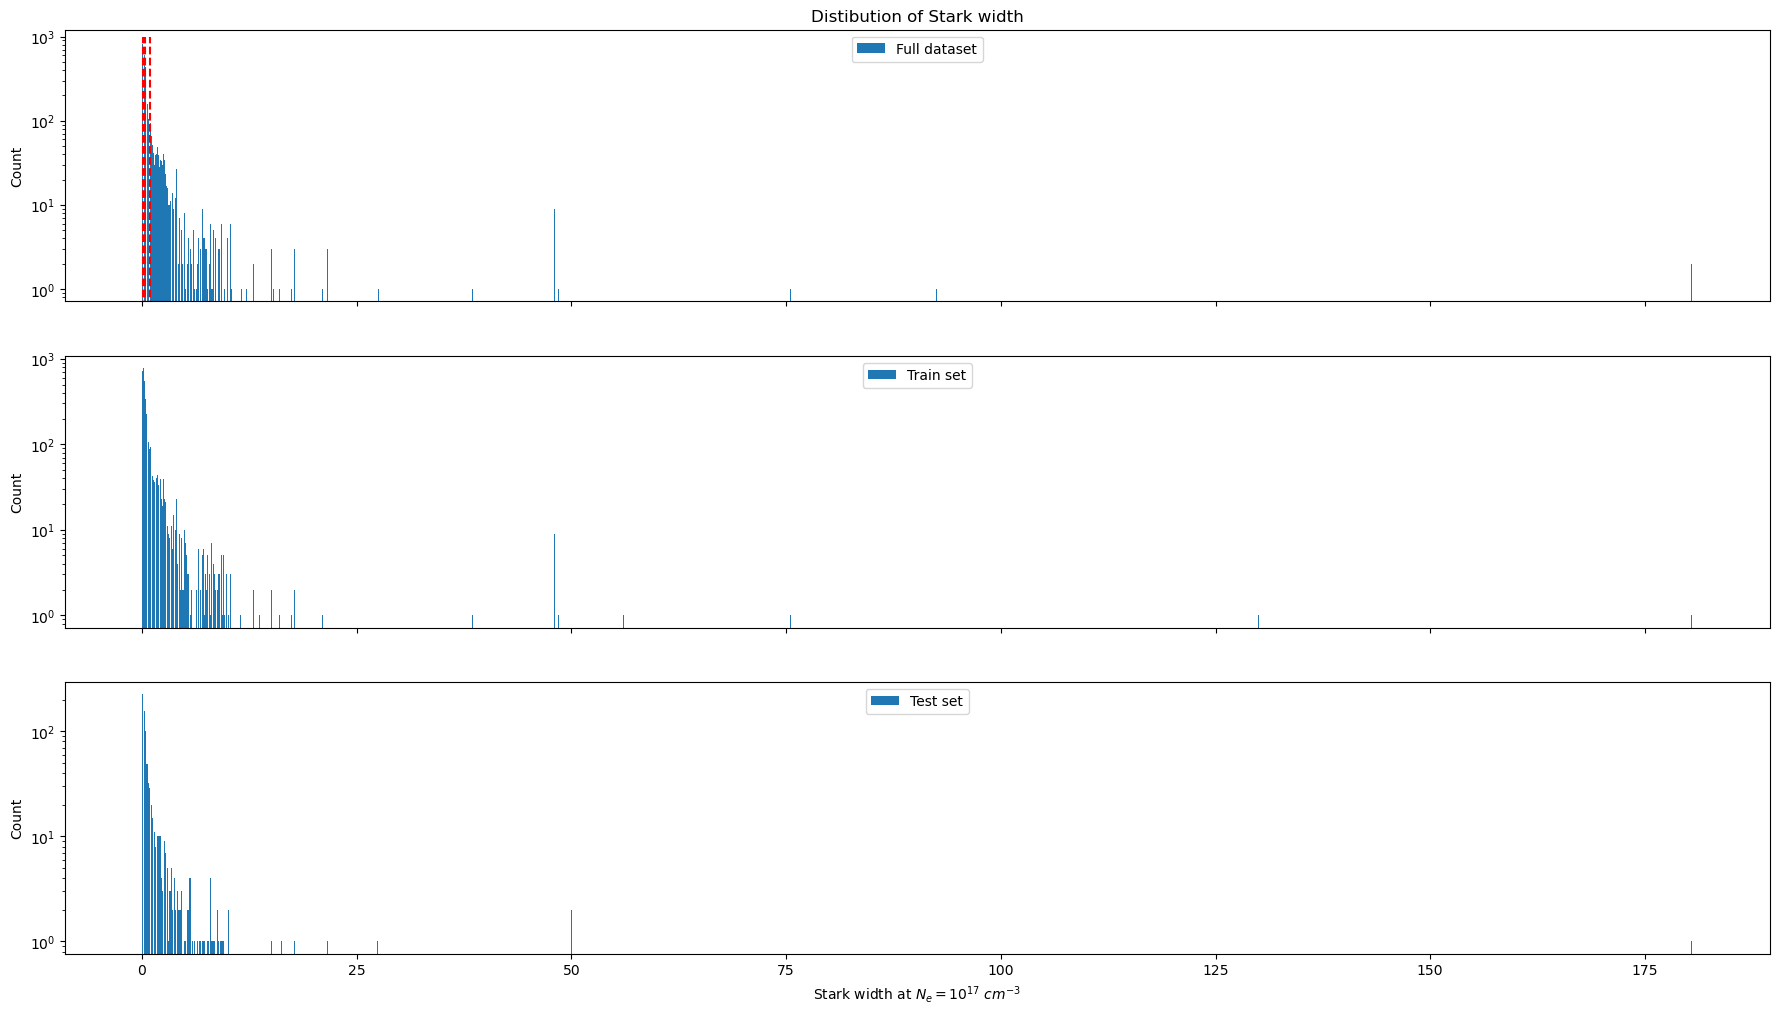

In [15]:
test_width_stats = target_width_test.describe()

fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = True)
axs[0].hist(target_width, bins='auto', log=True, rwidth = 0.8, label = 'Full dataset')
axs[1].hist(target_width_train, bins = 'auto', log = True, rwidth = 0.8, label = 'Train set')
axs[2].hist(target_width_test, bins = 'auto', log = True, rwidth = 0.8, label = 'Test set')


axs[0].vlines(x = data_width_stats['25%'], ymin = 0, ymax = 1000, ls='--', colors='r')
axs[0].vlines(x = data_width_stats['50%'], ymin = 0, ymax = 1000, ls='--', colors='r')
axs[0].vlines(x = data_width_stats['75%'], ymin = 0, ymax = 1000, ls='--', colors='r')
'''axs[1].vlines(x = test_width_stats['25%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_width_stats['50%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_width_stats['75%'], ymin = 0, ymax = 100, ls='--', colors='r')
'''
axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')
axs[2].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Count')
axs[2].set_ylabel('Count')
axs[0].set_title('Distibution of Stark width')

plt.show()

#plt.savefig('Width distribution.png', dpi = 300)

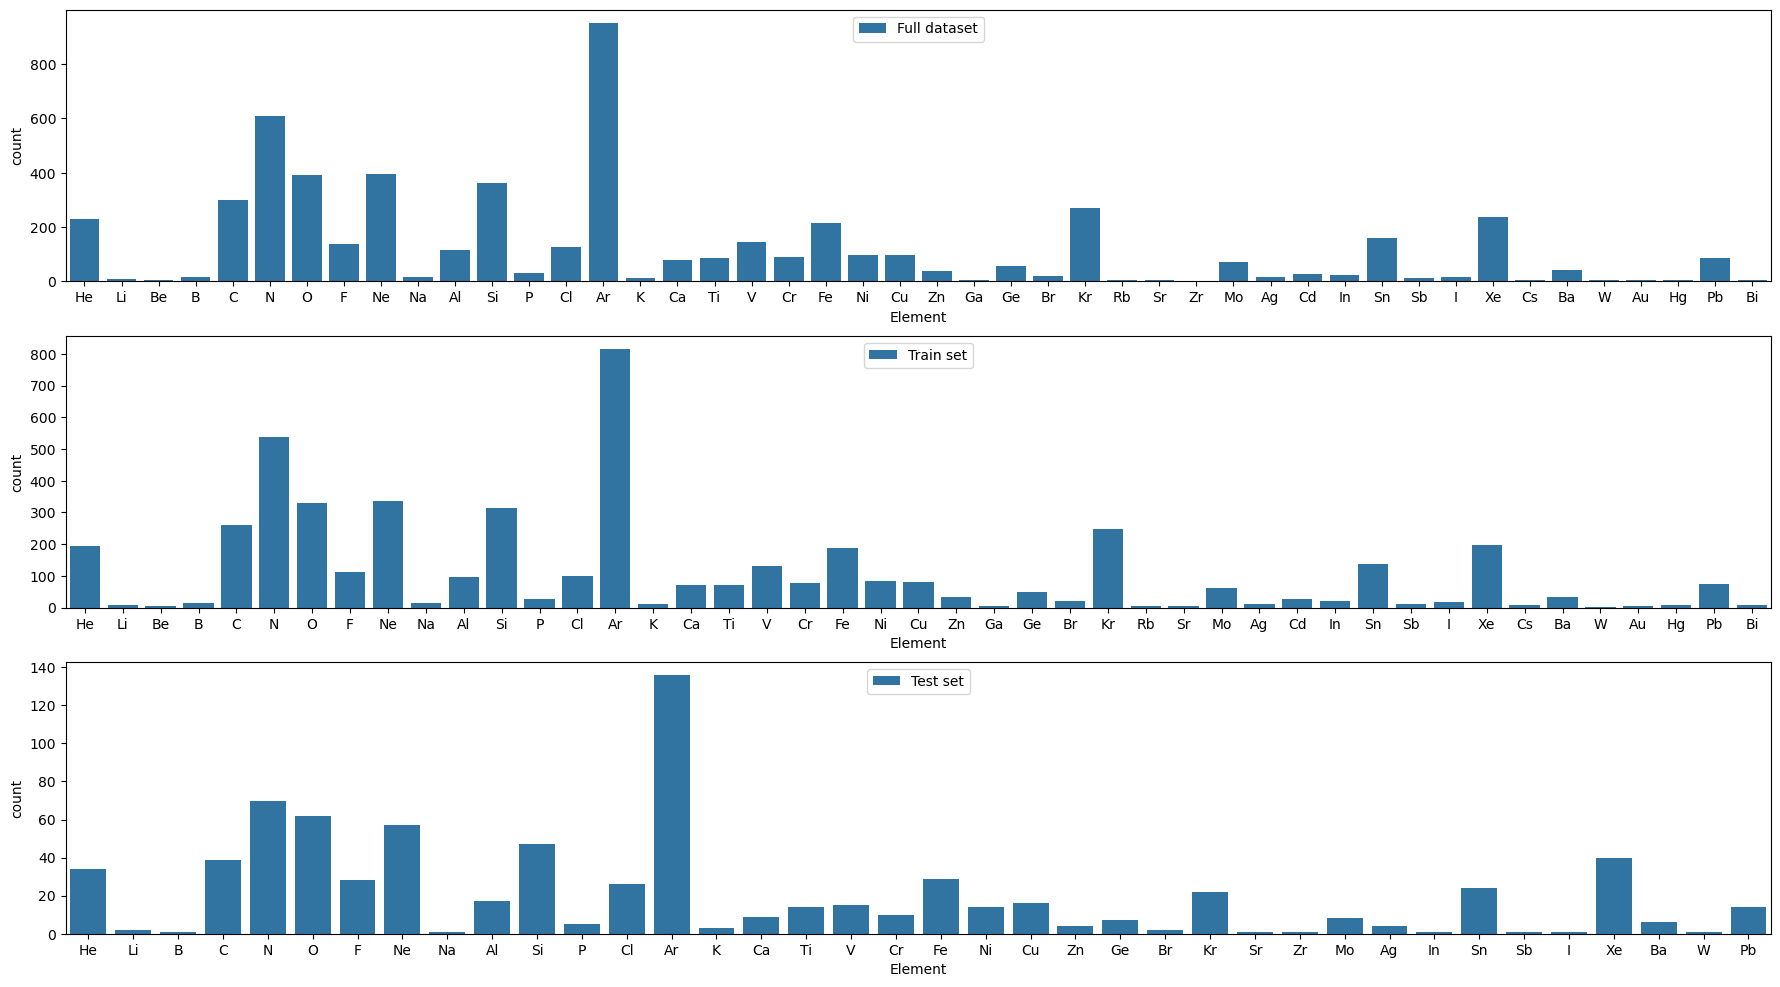

In [16]:
fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = False)
sns.countplot(data = data_width, x = 'Element',  ax = axs[0], label = 'Full dataset')
sns.countplot(data = data_width_train.sort_values(by = ['Z number']), x = 'Element',  ax = axs[1], label = 'Train set')
sns.countplot(data = data_width_test.sort_values(by = ['Z number']), x = 'Element', ax = axs[2], label = 'Test set')

axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')

plt.show()

# Shift data preprocessing

In [221]:
#Create dataset with shift data
data_shift = data[data['d (A)'].isna() == False]

#Remove unneccessary columns (i.e. those with one value only)
columns_to_drop = []
for col in data_shift.columns:
    if data_shift[col].nunique() == 1:
        columns_to_drop.append(col)
data_shift = data_shift.drop(columns = columns_to_drop)

#Creating data, target and labels for shift prediction
data_shift_elements = data_shift.loc[data_shift['Element'].isin(elements_to_exclude)]
data_shift = data_shift.drop(data_shift_elements.index)
data_shift = data_shift.sort_values(by=['Z number'])

#Separate targets from data
target_shift = data_shift['d (A)']
target_shift_elements = data_shift_elements['d (A)']

#Separate labels from data
label_shift = data_shift.loc[:, ['Element', 'Wavelength']]
label_shift_elements = data_shift_elements.loc[:, ['Element', 'Wavelength']]

#Remove width and shift values from data
data_shift = data_shift.drop(columns = ['w (A)', 'd (A)'])
data_shift_elements = data_shift_elements.drop(columns = ['w (A)', 'd (A)'])

#Remove uncertainty from data
data_shift = data_shift.drop(columns = ['w error (%)', 'd error (%)'])
data_shift_elements = data_shift_elements.drop(columns = ['w error (%)', 'd error (%)'])

In [222]:
#Split into train and test by quartiles
#Q1
data_test_q1, target_test_q1 = test_selection(data_shift,
                                              target_shift,
                                              p = 0.135,
                                              low_limit = 'min',
                                              up_limit = 25,
                                              random_state = 7)

#Q2
data_test_q2, target_test_q2 = test_selection(data_shift,
                                              target_shift,
                                              p = 0.135,
                                              low_limit = 25,
                                              up_limit = 50,
                                              random_state = 7)

#Q3
data_test_q3, target_test_q3 = test_selection(data_shift,
                                              target_shift,
                                              p = 0.135,
                                              low_limit = 50,
                                              up_limit = 75,
                                              random_state = 7)

#Q4
target_test_q4 = pd.Series()
while len(target_test_q4[target_test_q4 > 17.5]) < 1 or len(target_test_q4[(target_test_q4 > 11.5) & (target_test_q4 < 17.5)]) < 1:
    data_test_q4, target_test_q4 = test_selection(data_shift,
                                                target_shift,
                                                p = 0.135,
                                                low_limit = 75,
                                                random_state = None)
  
#Merging full train and test datasets
data_shift_test, target_shift_test = pd.concat([data_test_q1, data_test_q2]), pd.concat([target_test_q1, target_test_q2])
data_shift_test, target_shift_test = pd.concat([data_shift_test, data_test_q3]), pd.concat([target_shift_test, target_test_q3])
data_shift_test, target_shift_test = pd.concat([data_shift_test, data_test_q4]), pd.concat([target_shift_test, target_test_q4])

data_shift_train, target_shift_train = data_shift.drop(data_shift_test.index), target_shift.drop(target_shift_test.index)

## -- *OPTIONAL*-- Shift data visual description 

In [19]:
data_shift_stats = target_shift.describe()
print(data_shift_stats)

count    2219.000000
mean        0.446451
std         1.729293
min        -7.485437
25%        -0.021000
50%         0.021429
75%         0.221500
max        20.000000
Name: d (A), dtype: float64


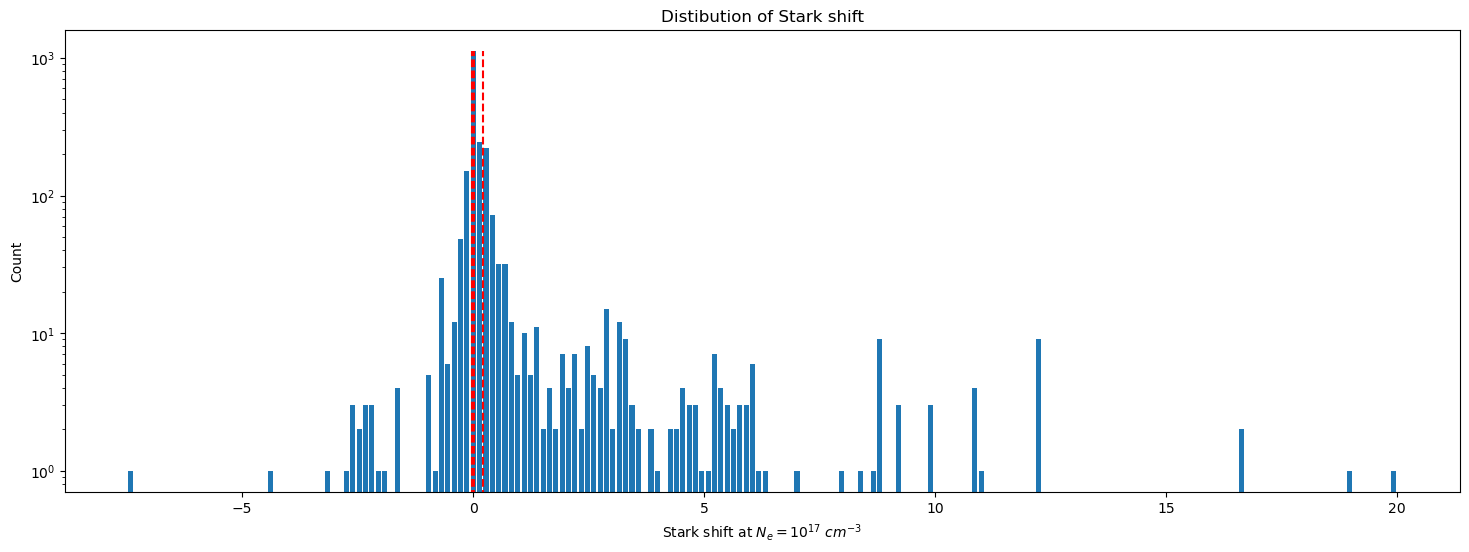

In [20]:
fig, ax = plt.subplots(figsize = (18, 6))
n, bins, patches = plt.hist(target_shift, bins=200, log=True, rwidth = 0.8)
ax.vlines(x = data_shift_stats['25%'], ymin = 0, ymax = np.max(n), ls='--', colors='r')
ax.vlines(x = data_shift_stats['50%'], ymin = 0, ymax = np.max(n), ls='--', colors='r')
ax.vlines(x = data_shift_stats['75%'], ymin = 0, ymax = np.max(n), ls='--', colors='r')

ax.set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
ax.set_ylabel('Count')
ax.set_title('Distibution of Stark shift')

plt.show()

#plt.savefig('Shift distribution.png', dpi = 300)

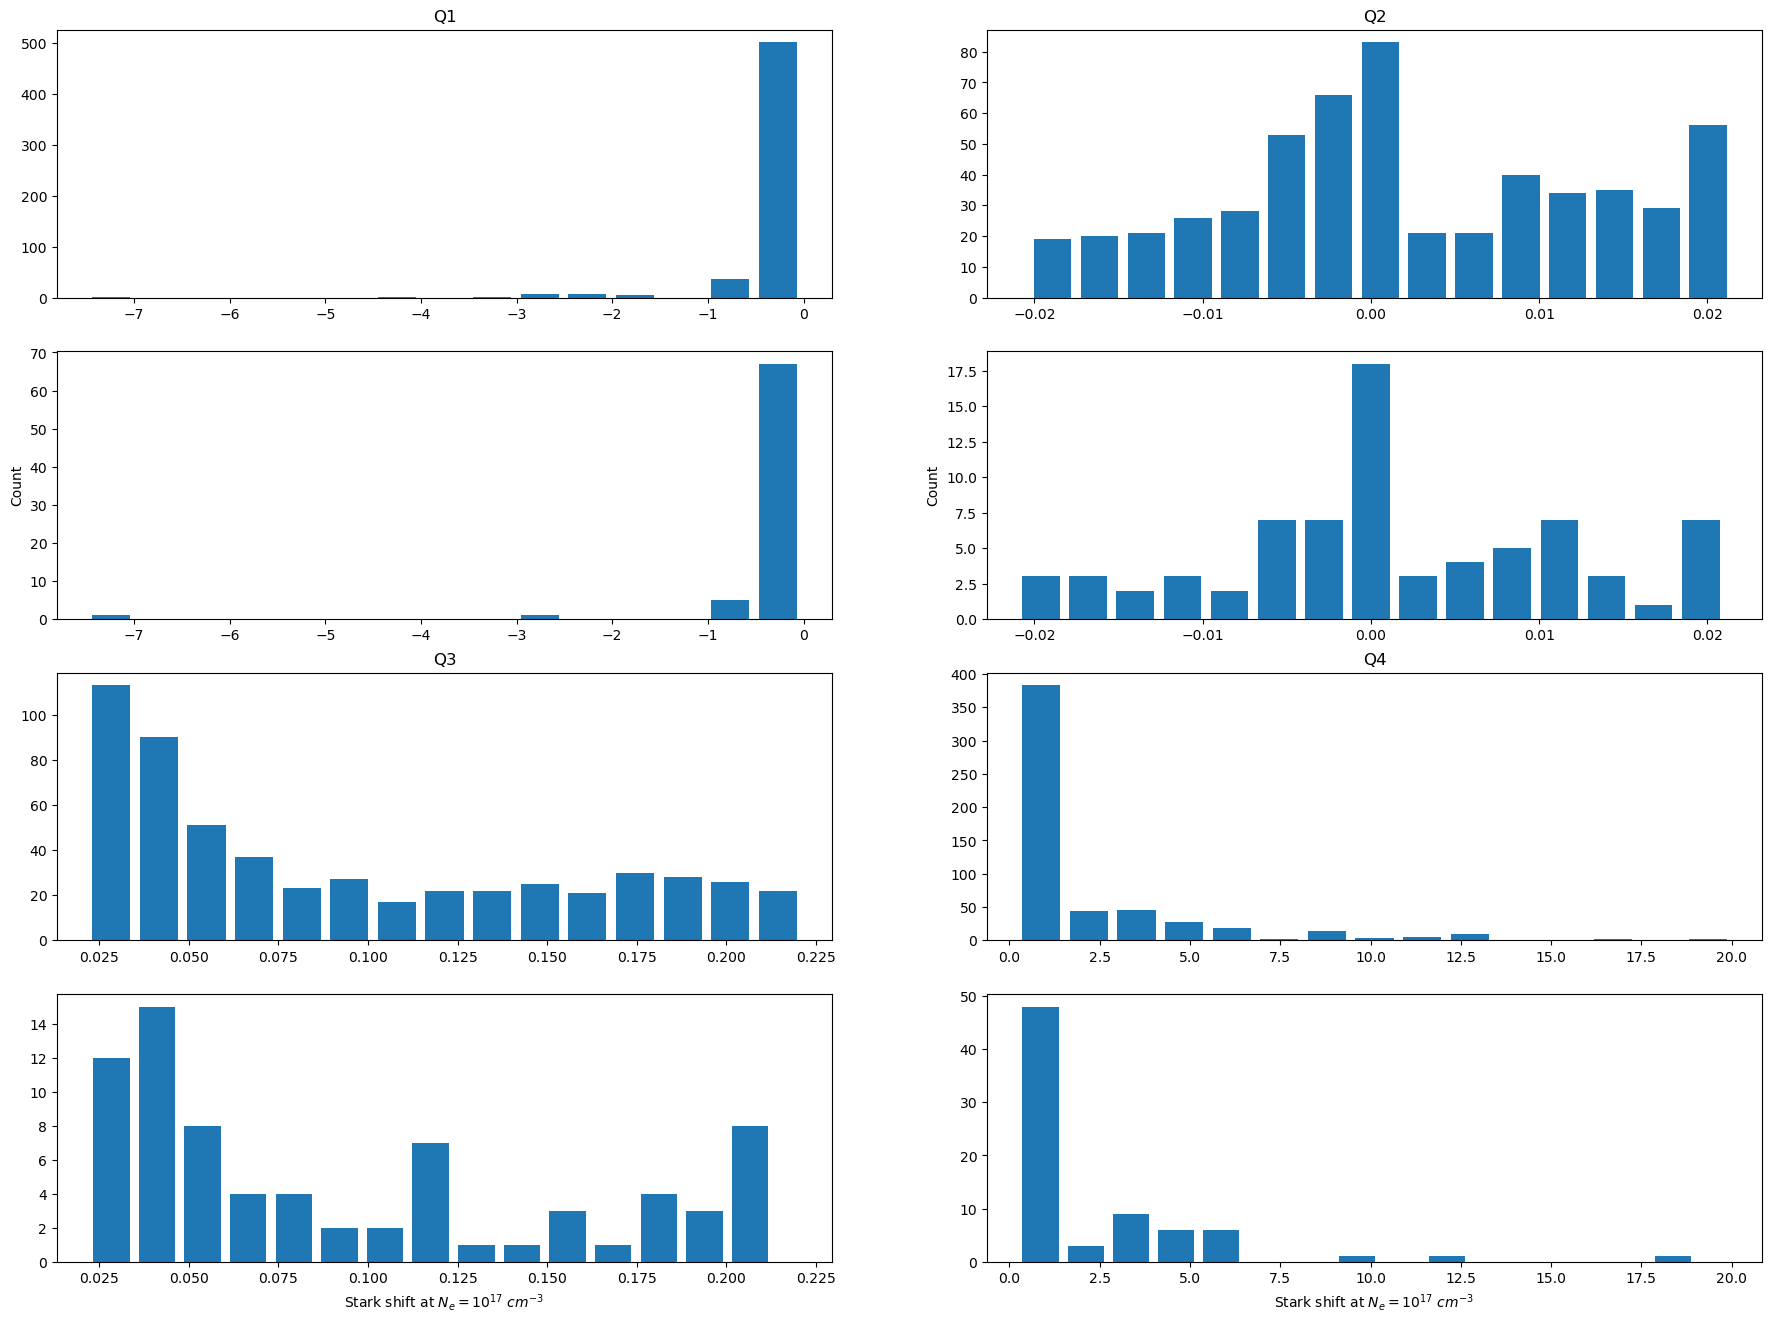

In [21]:
fig, axs = plt.subplots(4, 2, figsize = (22, 16), sharex = False)

axs[0, 0].hist(target_shift[target_shift <= data_shift_stats['25%']], bins=15, log=False, rwidth = 0.8)
axs[1, 0].hist(target_test_q1, bins = 15, rwidth = 0.8)

axs[0, 1].hist(target_shift[(target_shift > data_shift_stats['25%']) & (target_shift <= data_shift_stats['50%'])],
                            bins=15, log=False, rwidth = 0.8)
axs[1, 1].hist(target_test_q2, bins = 15, rwidth = 0.8)

axs[2, 0].hist(target_shift[(target_shift > data_shift_stats['50%']) & (target_shift <= data_shift_stats['75%'])],
                            bins=15, log=False, rwidth = 0.8)
axs[3, 0].hist(target_test_q3, bins = 15, rwidth = 0.8)

axs[2, 1].hist(target_shift[target_shift > data_shift_stats['75%']],
                            bins=15, log=False, rwidth = 0.8)
axs[3, 1].hist(target_test_q4, bins = 15, rwidth = 0.8)

axs[1, 0].sharex(axs[0, 0])
axs[3, 0].sharex(axs[2, 0])
axs[1, 1].sharex(axs[0, 1])
axs[3, 1].sharex(axs[2, 1])

axs[0, 0].set_title('Q1')
axs[2, 0].set_title('Q3')
axs[0, 1].set_title('Q2')
axs[2, 1].set_title('Q4')
axs[1, 0].set_ylabel('Count')
axs[1, 1].set_ylabel('Count')
axs[3, 0].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
axs[3, 1].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
plt.show()

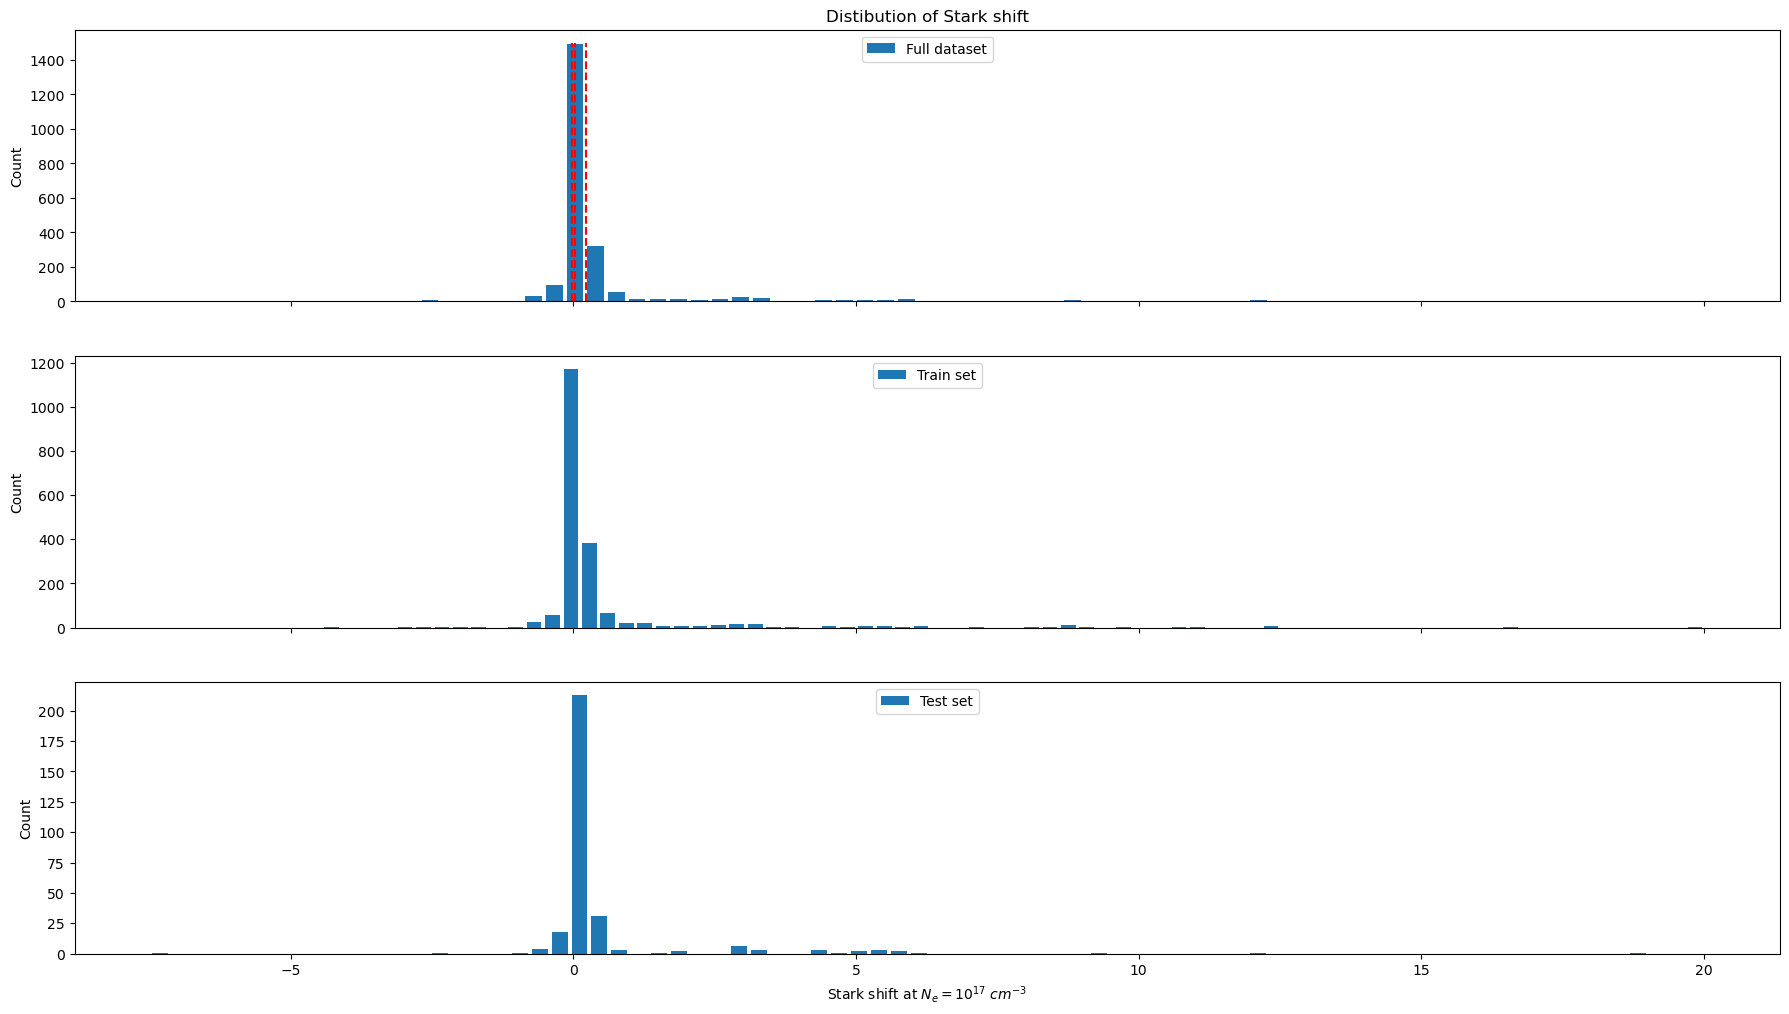

In [22]:
test_shift_stats = target_shift_test.describe()

fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = True)
axs[0].hist(target_shift, bins=75, log=False, rwidth = 0.8, label = 'Full dataset')
axs[1].hist(target_shift_train, bins = 75, log = False, rwidth = 0.8, label = 'Train set')
axs[2].hist(target_shift_test, bins = 75, log = False, rwidth = 0.8, label = 'Test set')


axs[0].vlines(x = data_shift_stats['25%'], ymin = 0, ymax = 1500, ls='--', colors='r')
axs[0].vlines(x = data_shift_stats['50%'], ymin = 0, ymax = 1500, ls='--', colors='r')
axs[0].vlines(x = data_shift_stats['75%'], ymin = 0, ymax = 1500, ls='--', colors='r')

axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')
axs[2].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Count')
axs[2].set_ylabel('Count')
axs[0].set_title('Distibution of Stark shift')

plt.show()

#plt.savefig('shift distribution.png', dpi = 300)

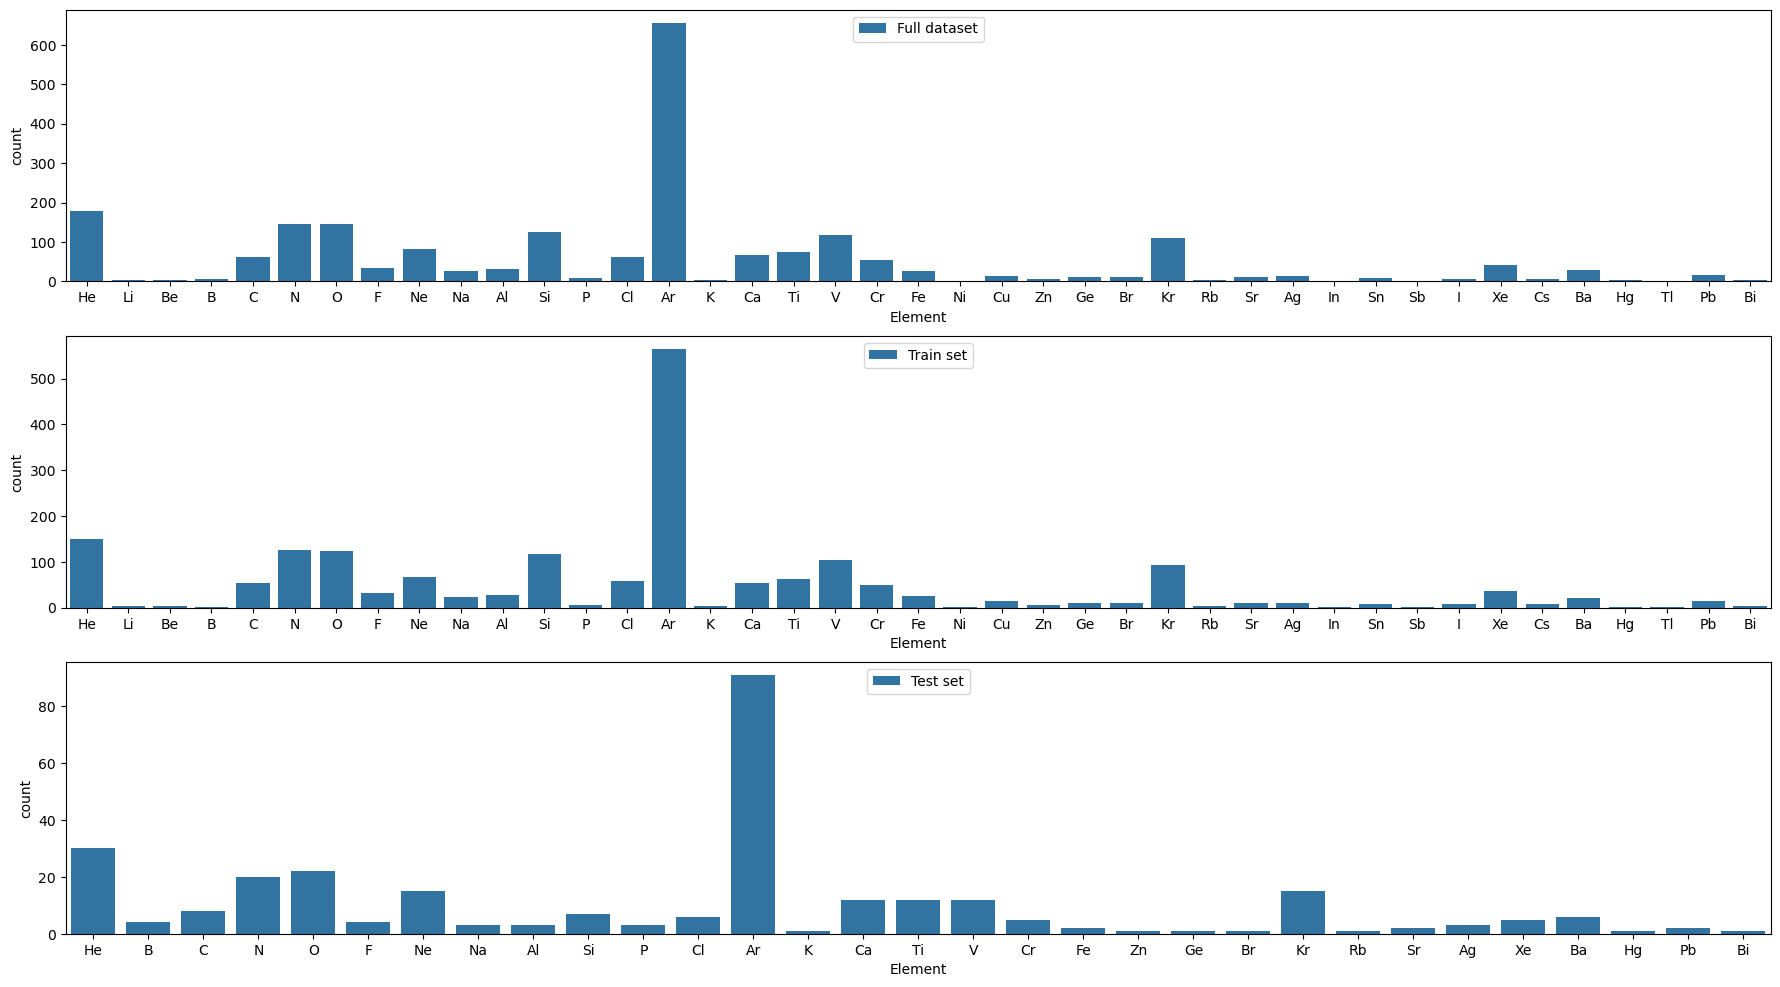

In [23]:
fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = False)
sns.countplot(data = data_shift, x = 'Element',  ax = axs[0], label = 'Full dataset')
sns.countplot(data = data_shift_train.sort_values(by = ['Z number']), x = 'Element',  ax = axs[1], label = 'Train set')
sns.countplot(data = data_shift_test.sort_values(by = ['Z number']), x = 'Element', ax = axs[2], label = 'Test set')

axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')

plt.show()

# Both data preprocessing (currently not used anywhere further)

In [223]:
#Selecting items for predicting both parameters simultaneously (currently not used anywhere further)
data_both = data[(data['w (A)'].isna() == False) & (data['d (A)'].isna() == False)]
data_both_elements = data_both.loc[data_both['Element'].isin(elements_to_exclude)]
data_both = data_both.drop(data_both_elements.index)
data_both = data_both.sort_values(by=['Z number'])

#Separate targets from data
target_both = data_both.loc[:, ['w (A)', 'd (A)']]
target_both_elements = data_both_elements.loc[:, ['w (A)', 'd (A)']]

#Separate labels from data
label_both = data_both.loc[:, ['Element', 'Wavelength']]
label_both_elements = data_both_elements.loc[:, ['Element', 'Wavelength']]

#Remove width and shift values from data
data_both = data_both.drop(columns = ['w (A)', 'd (A)'])
data_both_elements = data_both_elements.drop(columns = ['w (A)', 'd (A)'])

#Remove uncertainty from data
data_both = data_both.drop(columns = ['w error (%)', 'd error (%)'])
data_both_elements = data_both_elements.drop(columns = ['w error (%)', 'd error (%)'])

In [224]:
#Split into train and test
data_both_train, data_both_test, target_both_train, target_both_test = train_test_split(data_both,
                                                                                       target_both,
                                                                                       test_size = 0.114,
                                                                                       random_state = 7)

# Dataset modifications  (scaling, augmentation)

In [14]:
def unscale(y):
    return (np.exp(y) - 1) * epsilon

In [229]:
augmented_train_set = False#@param {type:"boolean"}
#@markdown Note: augmentation will be applied to width only 

#@markdown ---

#@markdown Select whether you'd like to work with 'width' or 'shift' predictions
parameter  = 'shift' #@param ["width", "shift", "both"]

#@markdown ---

#@markdown You can enter any reasonable value less than 180 Angstrom to limit the upper boundary of width walues. (not recommended to change)
width_threshold =  200#@param {type:"number"}

#@markdown ---

#@markdown Scale target values by the formula: $y_{scaled} = ln(1 + \frac{y_{raw}}{\epsilon})$
scaled_target = False#@param {type:"boolean"}
epsilon = 1e-3#@param {type: "number"}

#@markdown ---

#@markdown Normalize energies by the ionization energy for each particle
normalized_energy = True#@param {type:"boolean"}

#@markdown ---

apply_scaler = True#@param {type:"boolean"}

In [230]:
def constr_train_test(parameter, augmented_train_set, scaled_target, normalized_energy, print_stats = True):
    #Applying 'width' or 'shift' or 'both' selection
    if parameter == 'width':
        X_train, Y_train = data_width_train, target_width_train
        X_test, Y_test = data_width_test, target_width_test
        X_elem, Y_elem, L_elem = data_width_elements, target_width_elements, label_width_elements
    elif parameter == 'shift':
        X_train, Y_train = data_shift_train, target_shift_train
        X_test, Y_test = data_shift_test, target_shift_test
        X_elem, Y_elem, L_elem = data_shift_elements, target_shift_elements, label_shift_elements
    elif parameter == 'both':
        X_train, Y_train = data_both_train, target_both_train
        X_test, Y_test = data_both_test, target_both_test
        X_elem, Y_elem, L_elem = data_both_elements, target_both_elements, label_both_elements
    else:
        raise NameError('Incorrect parameter name selected')

    #Handling augmentation
    if augmented_train_set:
        factor = 1.05
        X_train_aug, Y_train_aug = X_train.copy(), Y_train.copy()
        for index, row in X_train.iterrows():
            row['T'] = row['T']*factor
            X_train_aug = pd.concat([X_train_aug, row.to_frame().T], ignore_index=True)
            Y_train_aug = pd.concat([Y_train_aug, pd.Series(Y_train.loc[index])], ignore_index=True)

            row['T'] = row['T']/factor**2
            X_train_aug = pd.concat([X_train_aug, row.to_frame().T], ignore_index=True)
            Y_train_aug = pd.concat([Y_train_aug, pd.Series(Y_train.loc[index])], ignore_index=True)
        X_train_aug = X_train_aug.astype(X_train.dtypes.to_dict())    

        X_train, Y_train = X_train_aug, Y_train_aug
        X_test,  Y_test  = X_test, Y_test

    #Shuffling
    X_train = X_train.sample(frac = 1, random_state = 777)
    Y_train = Y_train.sample(frac = 1, random_state = 777)

    #Applying upper boundary to width values
    X_train, Y_train = X_train.loc[Y_train.loc[Y_train < width_threshold].index], Y_train.loc[Y_train < width_threshold]
    X_test,  Y_test  = X_test.loc[Y_test.loc[Y_test < width_threshold].index], Y_test.loc[Y_test < width_threshold]
    X_elem,  Y_elem  = X_elem.loc[Y_elem.loc[Y_elem < width_threshold].index], Y_elem.loc[Y_elem < width_threshold]
    L_elem = L_elem.loc[Y_elem.loc[Y_elem < width_threshold].index]

    #Applying scaling of targets
    if scaled_target:
        Y_train = np.log(1 + Y_train / epsilon)
        Y_test  = np.log(1 + Y_test / epsilon)
        Y_elem  = np.log(1 + Y_elem / epsilon)

    #Normalizing energies
    if normalized_energy:
        X_train['E lower'], X_train['E upper'] = energy_to_fraction(X_train, 'E lower'), energy_to_fraction(X_train, 'E upper')
        X_test['E lower'],  X_test['E upper']  = energy_to_fraction(X_test, 'E lower'), energy_to_fraction(X_test, 'E upper')
        X_elem['E lower'],  X_elem['E upper']  = energy_to_fraction(X_elem, 'E lower'), energy_to_fraction(X_elem, 'E upper')
        X_train['Gap to ion'] = energy_to_fraction(X_train, 'Gap to ion')
        X_test['Gap to ion'] = energy_to_fraction(X_test, 'Gap to ion')
        X_elem['Gap to ion'] = energy_to_fraction(X_elem, 'Gap to ion')

    #Removing unneccesary columns:
    X_train = X_train.drop(columns=['Element', 'Wavelength', 'Z number'])
    X_test  = X_test.drop(columns=['Element', 'Wavelength', 'Z number'])
    X_elem  = X_elem.drop(columns=['Element', 'Wavelength', 'Z number'])

    scaler = StandardScaler()
    scaler.fit(X_train)

    if print_stats:
        print(f'Selected parameter: {parameter} \n')
        if augmented_train_set:
            print(f'Total number of items with known {parameter}: {X_train.shape[0]/3 + X_test.shape[0] + X_elem.shape[0]}')
        else:
            print(f'Total number of items with known {parameter}: {X_train.shape[0] + X_test.shape[0] + X_elem.shape[0]}')

        print(f'Size of training set: {X_train.shape[0]}')
        print(f'Size of ttest set: {X_test.shape[0]}')
        print(f'Size of elements-exclusive test set: {X_elem.shape[0]}')
    
    return(X_train, Y_train, X_test, Y_test, X_elem, Y_elem, L_elem, scaler)

X_train, Y_train, X_test, Y_test, X_elem, Y_elem, L_elem, scaler = constr_train_test(parameter,
                                                                                     augmented_train_set,
                                                                                     scaled_target,
                                                                                     normalized_energy)

Selected parameter: shift 

Total number of items with known shift: 2373
Size of training set: 1920
Size of ttest set: 300
Size of elements-exclusive test set: 153


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` i

0.27680344823407205
20.101980886945242


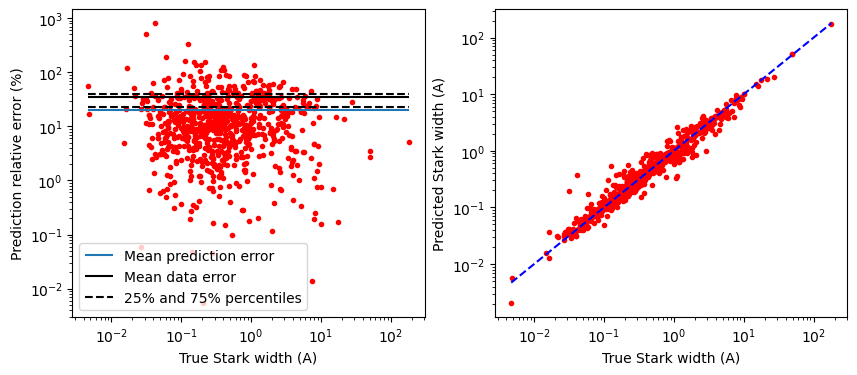

In [30]:
#Statistics for Test set
models = ['CatBoost_A+I_Enorm_Raw_Scaler']
models_d = create_models_dict(models, path = 'C:\\Users\\Alex\\Documents\\GitHub\\CatBoost')

if apply_scaler:
    print('Scaling')
    preds, preds_elem = plot_model_prediction(models_d,
                                              scaler.transform(X_train), Y_train,
                                              scaler.transform(X_test), Y_test,
                                              scaler.transform(X_elem), Y_elem, L_elem, 
                                              plot = False)
else:
    preds, preds_elem = plot_model_prediction(models_d,
                                              X_train, Y_train,
                                              X_test, Y_test,
                                              X_elem, Y_elem, L_elem, 
                                              plot = False)
    
print(mean_squared_error(Y_test, preds[models[0]], squared = False))
MREs = (np.abs(unscale(Y_test) - unscale(preds[models[0]].reshape(preds[models[0]].shape[0]))) / unscale(Y_test))*100
print(MREs.mean())

fig, ax = plt.subplots(1, 2, figsize = (10, 4))
ax[0].plot(unscale(Y_test), MREs, 'r.')
ax[0].hlines(MREs.mean(), np.amin(unscale(Y_test)), np.amax(unscale(Y_test)), label = 'Mean prediction error')
ax[0].hlines(34.438211, np.amin(unscale(Y_test)), np.amax(unscale(Y_test)), ls = '-', color = 'k', label = 'Mean data error')
ax[0].hlines(23., np.amin(unscale(Y_test)), np.amax(unscale(Y_test)), ls = '--', color = 'k', label = '25% and 75% percentiles')
ax[0].hlines(40., np.amin(unscale(Y_test)), np.amax(unscale(Y_test)), ls = '--', color = 'k')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend()
ax[0].set_xlabel('True Stark width (A)')
ax[0].set_ylabel('Prediction relative error (%)')
# ax[0].set_ylim(4e-2, 1.9e4)

ax[1].plot(unscale(Y_test), unscale(preds[models[0]].reshape(preds[models[0]].shape[0])), 'r.')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].plot([np.amin(unscale(Y_test)), np.amax(unscale(Y_test))],
           [np.amin(unscale(Y_test)), np.amax(unscale(Y_test))], color = 'b', ls = '--')
ax[1].set_xlabel('True Stark width (A)')
ax[1].set_ylabel('Predicted Stark width (A)')
# plt.savefig(f'XGB E_raw Raw No Test predictions.svg', transparent = True, format = 'svg')
plt.show()

In [ ]:
#Statistics for Elements set
models = ['LightGBM_A+I_Eraw_Raw_No']
models_d = create_models_dict(models, path = 'C:\\Users\\Alex\\Documents\\GitHub\\LightGBM')

if apply_scaler:
    print('Scaling')
    preds, preds_elem = plot_model_prediction(models_d,
                                              scaler.transform(X_train), Y_train,
                                              scaler.transform(X_test), Y_test,
                                              scaler.transform(X_elem), Y_elem, L_elem, 
                                              plot = False)
else:
    preds, preds_elem = plot_model_prediction(models_d,
                                              X_train, Y_train,
                                              X_test, Y_test,
                                              X_elem, Y_elem, L_elem, 
                                              plot = False)
    
print(mean_squared_error(Y_elem, preds_elem[models[0]], squared = False))
MREs = (np.abs(unscale(Y_elem) - unscale(preds_elem[models[0]].reshape(preds_elem[models[0]].shape[0]))) / unscale(Y_elem))*100
print(MREs.mean())

fig, ax = plt.subplots(1, 2, figsize = (10, 4))
ax[0].plot(unscale(Y_elem), MREs, 'r.')
ax[0].hlines(MREs.mean(), np.amin(unscale(Y_elem)), np.amax(unscale(Y_elem)), label = 'Mean prediction error')
ax[0].hlines(34.438211, np.amin(unscale(Y_elem)), np.amax(unscale(Y_elem)), ls = '-', color = 'k', label = 'Mean data error')
ax[0].hlines(23., np.amin(unscale(Y_elem)), np.amax(unscale(Y_elem)), ls = '--', color = 'k', label = '25% and 75% percentiles')
ax[0].hlines(40., np.amin(unscale(Y_elem)), np.amax(unscale(Y_elem)), ls = '--', color = 'k')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend()
ax[0].set_xlabel('True Stark width (A)')
ax[0].set_ylabel('Prediction relative error (%)')
# ax[0].set_ylim(4e-2, 1.9e4)

ax[1].plot(unscale(Y_elem), unscale(preds_elem[models[0]].reshape(preds_elem[models[0]].shape[0])), 'r.')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].plot([np.amin(unscale(Y_elem)), np.amax(unscale(Y_elem))],
           [np.amin(unscale(Y_elem)), np.amax(unscale(Y_elem))], color = 'b', ls = '--')
ax[1].set_xlabel('True Stark width (A)')
ax[1].set_ylabel('Predicted Stark width (A)')
# plt.savefig(f'XGB E_raw Raw No Test predictions.svg', transparent = True, format = 'svg')
plt.show()

Scaling


C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.6238487717156169
101.89362265937912


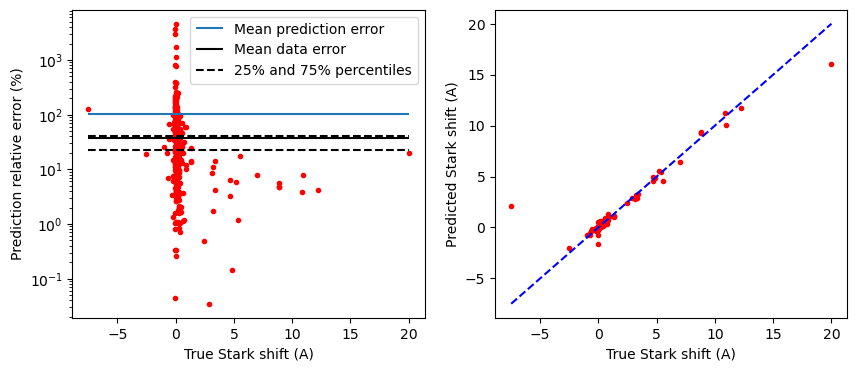

In [233]:
#Statistics for Shift Test set
models = ['RF_Shift_Enorm_Raw_Scaler']
models_d = create_models_dict(models, path = 'C:\\Users\\Alex\\Documents\\GitHub\\RF')

if apply_scaler:
    print('Scaling')
    preds, preds_elem = plot_model_prediction(models_d,
                                              scaler.transform(X_train), Y_train,
                                              scaler.transform(X_test), Y_test,
                                              scaler.transform(X_elem), Y_elem, L_elem, 
                                              plot = False)
else:
    preds, preds_elem = plot_model_prediction(models_d,
                                              X_train, Y_train,
                                              X_test, Y_test,
                                              X_elem, Y_elem, L_elem, 
                                              plot = False)
    
print(mean_squared_error(Y_test, preds[models[0]], squared = False))
MREs = ((np.abs(Y_test - preds[models[0]].reshape(preds[models[0]].shape[0])) / np.abs(Y_test))*100)
MREs.replace(np.inf, np.nan, inplace=True)
print(MREs.mean())

fig, ax = plt.subplots(1, 2, figsize = (10, 4))
ax[0].plot(Y_test, MREs, 'r.')
ax[0].hlines(MREs.mean(), np.amin(Y_test), np.amax(Y_test), label = 'Mean prediction error')
ax[0].hlines(37.619792, np.amin(Y_test), np.amax(Y_test), ls = '-', color = 'k', label = 'Mean data error')
ax[0].hlines(23., np.amin(Y_test), np.amax(Y_test), ls = '--', color = 'k', label = '25% and 75% percentiles')
ax[0].hlines(40., np.amin(Y_test), np.amax(Y_test), ls = '--', color = 'k')
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_xlabel('True Stark shift (A)')
ax[0].set_ylabel('Prediction relative error (%)')
# ax[0].set_ylim(4e-2, 1.9e4)

ax[1].plot(Y_test, preds[models[0]].reshape(preds[models[0]].shape[0]), 'r.')
ax[1].plot([np.amin(Y_test), np.amax(Y_test)],
           [np.amin(Y_test), np.amax(Y_test)], color = 'b', ls = '--')
ax[1].set_xlabel('True Stark shift (A)')
ax[1].set_ylabel('Predicted Stark shift (A)')
# plt.savefig(f'XGB E_raw Raw No Test predictions.svg', transparent = True, format = 'svg')
plt.show()

Scaling


C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.6981466381218445
332.6166172134416


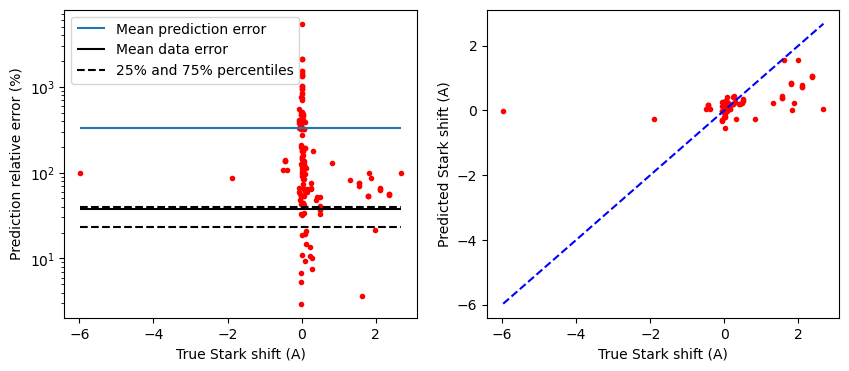

In [234]:
#Statistics for Shift Elements set
models = ['RF_Shift_Enorm_Raw_Scaler']
models_d = create_models_dict(models, path = 'C:\\Users\\Alex\\Documents\\GitHub\\RF')

if apply_scaler:
    print('Scaling')
    preds, preds_elem = plot_model_prediction(models_d,
                                              scaler.transform(X_train), Y_train,
                                              scaler.transform(X_test), Y_test,
                                              scaler.transform(X_elem), Y_elem, L_elem, 
                                              plot = False)
else:
    preds, preds_elem = plot_model_prediction(models_d,
                                              X_train, Y_train,
                                              X_test, Y_test,
                                              X_elem, Y_elem, L_elem, 
                                              plot = False)
    
print(mean_squared_error(Y_elem, preds_elem[models[0]], squared = False))
MREs = (np.abs(Y_elem - preds_elem[models[0]].reshape(preds_elem[models[0]].shape[0])) / np.abs(Y_elem))*100
MREs.replace(np.inf, np.nan, inplace=True)
print(MREs.mean())

fig, ax = plt.subplots(1, 2, figsize = (10, 4))
ax[0].plot(Y_elem, MREs, 'r.')
ax[0].hlines(MREs.mean(), np.amin(Y_elem), np.amax(Y_elem), label = 'Mean prediction error')
ax[0].hlines(37.619792, np.amin(Y_elem), np.amax(Y_elem), ls = '-', color = 'k', label = 'Mean data error')
ax[0].hlines(23., np.amin(Y_elem), np.amax(Y_elem), ls = '--', color = 'k', label = '25% and 75% percentiles')
ax[0].hlines(40., np.amin(Y_elem), np.amax(Y_elem), ls = '--', color = 'k')
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_xlabel('True Stark shift (A)')
ax[0].set_ylabel('Prediction relative error (%)')
# ax[0].set_ylim(4e-2, 1.9e4)

ax[1].plot(Y_elem, preds_elem[models[0]].reshape(preds_elem[models[0]].shape[0]), 'r.')
ax[1].plot([np.amin(Y_elem), np.amax(Y_elem)],
           [np.amin(Y_elem), np.amax(Y_elem)], color = 'b', ls = '--')
ax[1].set_xlabel('True Stark shift (A)')
ax[1].set_ylabel('Predicted Stark shift (A)')
# plt.savefig(f'XGB E_raw Raw No Test predictions.svg', transparent = True, format = 'svg')
plt.show()

### Normalizing shells population

In [87]:
def population_to_fraction(data):
    shells = ['1s', '2s', '2p', '3s', '3p', '3d', '4s', '4p', '4d', '4f', '5s', '5p', '5d', '5f', '5g',
              '6s', '6p', '6d', '7s', '7p', '1s.1', '2s.1', '2p.1', '3s.1', '3p.1', '3d.1', '4s.1',
              '4p.1', '4d.1', '4f.1', '5s.1', '5p.1', '5d.1', '5f.1', '5g.1', '6s.1', '6p.1', '6d.1',
              '6f', '6g', '6h', '7s.1', '7p.1', '7d', '8s', '8p', '8d', '9s', '10s', '11s']

    for shell in shells:
        if 's' in shell:
            max_e = 2
        elif 'p' in shell:
            max_e = 6
        elif 'd' in shell:
            max_e = 10
        elif 'f' in shell:
            max_e = 14
        elif 'g' in shell:
            max_e = 18
        elif 'h' in shell:
            max_e = 22
        else:
            raise NameError(f'Shell {shell} in not specified')
        data[f'{shell}'] = data[f'{shell}']/max_e
    return data

Scaling


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

0.32385636445539934
23.487765528420553


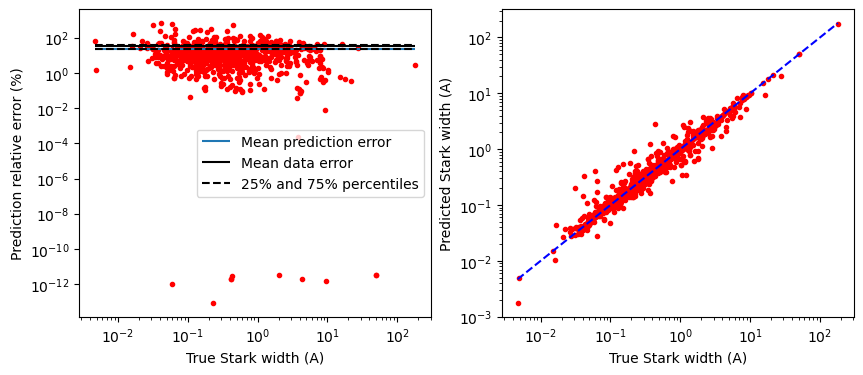

In [121]:
normalized_populations = True

if normalized_populations:
    X_train = population_to_fraction(X_train)
    X_test  = population_to_fraction(X_test)
    X_elem  = population_to_fraction(X_elem)

model = 'RF'
models = [f'{model}_A+I_Enorm_Aug_Scaler']
models_d = create_models_dict(models, path = f'C:\\Users\\Alex\\Documents\\GitHub\\{model}')

if apply_scaler:
    print('Scaling')
    preds, preds_elem = plot_model_prediction(models_d,
                                              scaler.transform(X_train), Y_train,
                                              scaler.transform(X_test), Y_test,
                                              scaler.transform(X_elem), Y_elem, L_elem, 
                                              plot = False)
else:
    preds, preds_elem = plot_model_prediction(models_d,
                                              X_train, Y_train,
                                              X_test, Y_test,
                                              X_elem, Y_elem, L_elem, 
                                              plot = False)
    
print(mean_squared_error(Y_test, preds[models[0]], squared = False))
MREs = (np.abs(unscale(Y_test) - unscale(preds[models[0]].reshape(preds[models[0]].shape[0]))) / unscale(Y_test))*100
print(MREs.mean())

fig, ax = plt.subplots(1, 2, figsize = (10, 4))
ax[0].plot(unscale(Y_test), MREs, 'r.')
ax[0].hlines(MREs.mean(), np.amin(unscale(Y_test)), np.amax(unscale(Y_test)), label = 'Mean prediction error')
ax[0].hlines(34.438211, np.amin(unscale(Y_test)), np.amax(unscale(Y_test)), ls = '-', color = 'k', label = 'Mean data error')
ax[0].hlines(23., np.amin(unscale(Y_test)), np.amax(unscale(Y_test)), ls = '--', color = 'k', label = '25% and 75% percentiles')
ax[0].hlines(40., np.amin(unscale(Y_test)), np.amax(unscale(Y_test)), ls = '--', color = 'k')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend()
ax[0].set_xlabel('True Stark width (A)')
ax[0].set_ylabel('Prediction relative error (%)')
# ax[0].set_ylim(4e-2, 1.9e4)

ax[1].plot(unscale(Y_test), unscale(preds[models[0]].reshape(preds[models[0]].shape[0])), 'r.')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].plot([np.amin(unscale(Y_test)), np.amax(unscale(Y_test))],
           [np.amin(unscale(Y_test)), np.amax(unscale(Y_test))], color = 'b', ls = '--')
ax[1].set_xlabel('True Stark width (A)')
ax[1].set_ylabel('Predicted Stark width (A)')
# plt.savefig(f'XGB E_raw Raw No Test predictions.svg', transparent = True, format = 'svg')
plt.show()

In [341]:
def train_loop(dataloader, model, criterion, optimizer):
    num_batches = len(dataloader)
    print(f'n batches = {num_batches}')
    train_loss = 0

    for x, y in dataloader:
        # Compute prediction and loss
        pred = model(x.to(device))
        loss = criterion(pred, y.to(device))
        
        # Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= num_batches
    print(f"Train loss: {train_loss:>8f}")

    return train_loss

def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    test_loss, correct = 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            # Compute prediction and loss
            pred = model(x.to(device))
            loss = criterion(pred, y.to(device))

            test_loss += loss.item()

    test_loss /= num_batches
    print(f"Test loss: {test_loss:>8f}\n")

    return test_loss

In [427]:
# for plotting
loss_history = {"train": [], "test": []}
num_epochs = 1000
batch_size = 4096
learning_rate = 1e-4

#model = Simple_NN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
device = 'cpu'

train_dataloader = DataLoader(TensorDataset(torch.from_numpy(scaler.transform(X_train).astype(np.float32)),
                                            torch.from_numpy(Y_train.to_numpy().astype(np.float32))),
                              batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(TensorDataset(torch.from_numpy(scaler.transform(X_test).astype(np.float32)),
                                           torch.from_numpy(Y_test.to_numpy().astype(np.float32))),
                             batch_size=batch_size, shuffle=False)

for i in range(num_epochs):
    print(f"Epoch {i+1}")
    train_loss = train_loop(train_dataloader, model, criterion, optimizer)
    test_loss = test_loop(test_dataloader, model, criterion)

    loss_history["train"].append(train_loss)
    loss_history["test"].append(test_loss)
print("Done!")

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

Epoch 1
n batches = 4
Train loss: 1.979596
Test loss: 2.057615

Epoch 2
n batches = 4
Train loss: 1.980281
Test loss: 2.022543

Epoch 3
n batches = 4
Train loss: 1.964779
Test loss: 2.023669

Epoch 4
n batches = 4
Train loss: 1.955594
Test loss: 2.025782

Epoch 5
n batches = 4
Train loss: 1.959585
Test loss: 2.018857

Epoch 6
n batches = 4
Train loss: 1.953056
Test loss: 2.022148

Epoch 7
n batches = 4
Train loss: 1.949008
Test loss: 2.019652

Epoch 8
n batches = 4
Train loss: 1.953726
Test loss: 2.018851

Epoch 9
n batches = 4
Train loss: 1.953162
Test loss: 2.019466

Epoch 10
n batches = 4
Train loss: 1.950046
Test loss: 2.018790

Epoch 11
n batches = 4
Train loss: 1.955748
Test loss: 2.019139

Epoch 12
n batches = 4
Train loss: 1.942445
Test loss: 2.018863

Epoch 13
n batches = 4
Train loss: 1.960531
Test loss: 2.018691

Epoch 14
n batches = 4
Train loss: 1.949481
Test loss: 2.019404

Epoch 15
n batches = 4
Train loss: 1.948734
Test loss: 2.018676

Epoch 16
n batches = 4
Train loss:

Train loss: 1.941996
Test loss: 2.018652

Epoch 129
n batches = 4
Train loss: 1.954345
Test loss: 2.018667

Epoch 130
n batches = 4
Train loss: 1.959811
Test loss: 2.018711

Epoch 131
n batches = 4
Train loss: 1.957631
Test loss: 2.019117

Epoch 132
n batches = 4
Train loss: 1.963231
Test loss: 2.018755

Epoch 133
n batches = 4
Train loss: 1.972421
Test loss: 2.019188

Epoch 134
n batches = 4
Train loss: 1.964863
Test loss: 2.021350

Epoch 135
n batches = 4
Train loss: 1.958644
Test loss: 2.019902

Epoch 136
n batches = 4
Train loss: 1.953945
Test loss: 2.018721

Epoch 137
n batches = 4
Train loss: 1.962063
Test loss: 2.018990

Epoch 138
n batches = 4
Train loss: 1.960842
Test loss: 2.018798

Epoch 139
n batches = 4
Train loss: 1.951713
Test loss: 2.018690

Epoch 140
n batches = 4
Train loss: 1.951982
Test loss: 2.018723

Epoch 141
n batches = 4
Train loss: 1.962854
Test loss: 2.019606

Epoch 142
n batches = 4
Train loss: 1.956933
Test loss: 2.019235

Epoch 143
n batches = 4
Train loss

Train loss: 1.955087
Test loss: 2.018675

Epoch 254
n batches = 4
Train loss: 1.971230
Test loss: 2.018729

Epoch 255
n batches = 4
Train loss: 1.966825
Test loss: 2.018966

Epoch 256
n batches = 4
Train loss: 1.940629
Test loss: 2.018685

Epoch 257
n batches = 4
Train loss: 1.950709
Test loss: 2.018884

Epoch 258
n batches = 4
Train loss: 1.947985
Test loss: 2.018944

Epoch 259
n batches = 4
Train loss: 1.951130
Test loss: 2.018655

Epoch 260
n batches = 4
Train loss: 1.957013
Test loss: 2.018651

Epoch 261
n batches = 4
Train loss: 1.959829
Test loss: 2.018651

Epoch 262
n batches = 4
Train loss: 1.951637
Test loss: 2.018659

Epoch 263
n batches = 4
Train loss: 1.960620
Test loss: 2.018665

Epoch 264
n batches = 4
Train loss: 1.950726
Test loss: 2.018760

Epoch 265
n batches = 4
Train loss: 1.945733
Test loss: 2.018882

Epoch 266
n batches = 4
Train loss: 1.958366
Test loss: 2.018655

Epoch 267
n batches = 4
Train loss: 1.954917
Test loss: 2.019418

Epoch 268
n batches = 4
Train loss

Train loss: 1.954028
Test loss: 2.018781

Epoch 380
n batches = 4
Train loss: 1.954628
Test loss: 2.018859

Epoch 381
n batches = 4
Train loss: 1.950118
Test loss: 2.019070

Epoch 382
n batches = 4
Train loss: 1.950025
Test loss: 2.018666

Epoch 383
n batches = 4
Train loss: 1.945969
Test loss: 2.018657

Epoch 384
n batches = 4
Train loss: 1.949224
Test loss: 2.019032

Epoch 385
n batches = 4
Train loss: 1.942248
Test loss: 2.018745

Epoch 386
n batches = 4
Train loss: 1.953308
Test loss: 2.018651

Epoch 387
n batches = 4
Train loss: 1.955084
Test loss: 2.019050

Epoch 388
n batches = 4
Train loss: 1.951480
Test loss: 2.018793

Epoch 389
n batches = 4
Train loss: 1.961891
Test loss: 2.018726

Epoch 390
n batches = 4
Train loss: 1.954214
Test loss: 2.018652

Epoch 391
n batches = 4
Train loss: 1.959894
Test loss: 2.018694

Epoch 392
n batches = 4
Train loss: 1.946887
Test loss: 2.018746

Epoch 393
n batches = 4
Train loss: 1.949788
Test loss: 2.018822

Epoch 394
n batches = 4
Train loss

Train loss: 1.947058
Test loss: 2.018676

Epoch 505
n batches = 4
Train loss: 1.960708
Test loss: 2.018656

Epoch 506
n batches = 4
Train loss: 1.961581
Test loss: 2.018829

Epoch 507
n batches = 4
Train loss: 1.958381
Test loss: 2.018670

Epoch 508
n batches = 4
Train loss: 1.951613
Test loss: 2.018726

Epoch 509
n batches = 4
Train loss: 1.958123
Test loss: 2.018663

Epoch 510
n batches = 4
Train loss: 1.947334
Test loss: 2.019157

Epoch 511
n batches = 4
Train loss: 1.951720
Test loss: 2.018924

Epoch 512
n batches = 4
Train loss: 1.962187
Test loss: 2.018657

Epoch 513
n batches = 4
Train loss: 1.962116
Test loss: 2.018814

Epoch 514
n batches = 4
Train loss: 1.951659
Test loss: 2.018655

Epoch 515
n batches = 4
Train loss: 1.957777
Test loss: 2.018729

Epoch 516
n batches = 4
Train loss: 1.947910
Test loss: 2.018731

Epoch 517
n batches = 4
Train loss: 1.942848
Test loss: 2.018654

Epoch 518
n batches = 4
Train loss: 1.966650
Test loss: 2.018800

Epoch 519
n batches = 4
Train loss

Train loss: 1.952180
Test loss: 2.018745

Epoch 630
n batches = 4
Train loss: 1.961375
Test loss: 2.019188

Epoch 631
n batches = 4
Train loss: 1.962702
Test loss: 2.018771

Epoch 632
n batches = 4
Train loss: 1.960063
Test loss: 2.018736

Epoch 633
n batches = 4
Train loss: 1.939260
Test loss: 2.018804

Epoch 634
n batches = 4
Train loss: 1.957374
Test loss: 2.018950

Epoch 635
n batches = 4
Train loss: 1.953002
Test loss: 2.018879

Epoch 636
n batches = 4
Train loss: 1.959560
Test loss: 2.018670

Epoch 637
n batches = 4
Train loss: 1.948815
Test loss: 2.018821

Epoch 638
n batches = 4
Train loss: 1.950246
Test loss: 2.018765

Epoch 639
n batches = 4
Train loss: 1.947752
Test loss: 2.018802

Epoch 640
n batches = 4
Train loss: 1.957154
Test loss: 2.018722

Epoch 641
n batches = 4
Train loss: 1.962273
Test loss: 2.018714

Epoch 642
n batches = 4
Train loss: 1.956634
Test loss: 2.018663

Epoch 643
n batches = 4
Train loss: 1.949280
Test loss: 2.019226

Epoch 644
n batches = 4
Train loss

Train loss: 1.958823
Test loss: 2.018849

Epoch 756
n batches = 4
Train loss: 1.962693
Test loss: 2.018736

Epoch 757
n batches = 4
Train loss: 1.952022
Test loss: 2.019175

Epoch 758
n batches = 4
Train loss: 1.950528
Test loss: 2.019064

Epoch 759
n batches = 4
Train loss: 1.953606
Test loss: 2.018842

Epoch 760
n batches = 4
Train loss: 1.958797
Test loss: 2.018687

Epoch 761
n batches = 4
Train loss: 1.943194
Test loss: 2.018750

Epoch 762
n batches = 4
Train loss: 1.962635
Test loss: 2.018723

Epoch 763
n batches = 4
Train loss: 1.957953
Test loss: 2.018668

Epoch 764
n batches = 4
Train loss: 1.952210
Test loss: 2.018675

Epoch 765
n batches = 4
Train loss: 1.942698
Test loss: 2.018798

Epoch 766
n batches = 4
Train loss: 1.959045
Test loss: 2.018667

Epoch 767
n batches = 4
Train loss: 1.946003
Test loss: 2.019008

Epoch 768
n batches = 4
Train loss: 1.950014
Test loss: 2.019104

Epoch 769
n batches = 4
Train loss: 1.956132
Test loss: 2.018656

Epoch 770
n batches = 4
Train loss

Train loss: 1.954265
Test loss: 2.018686

Epoch 881
n batches = 4
Train loss: 1.957656
Test loss: 2.018709

Epoch 882
n batches = 4
Train loss: 1.952445
Test loss: 2.018689

Epoch 883
n batches = 4
Train loss: 1.951970
Test loss: 2.018730

Epoch 884
n batches = 4
Train loss: 1.949392
Test loss: 2.018721

Epoch 885
n batches = 4
Train loss: 1.955131
Test loss: 2.018782

Epoch 886
n batches = 4
Train loss: 1.949275
Test loss: 2.018669

Epoch 887
n batches = 4
Train loss: 1.950544
Test loss: 2.018702

Epoch 888
n batches = 4
Train loss: 1.945873
Test loss: 2.018655

Epoch 889
n batches = 4
Train loss: 1.958477
Test loss: 2.018822

Epoch 890
n batches = 4
Train loss: 1.962201
Test loss: 2.019753

Epoch 891
n batches = 4
Train loss: 1.961135
Test loss: 2.018856

Epoch 892
n batches = 4
Train loss: 1.966844
Test loss: 2.018928

Epoch 893
n batches = 4
Train loss: 1.949426
Test loss: 2.018682

Epoch 894
n batches = 4
Train loss: 1.953966
Test loss: 2.018693

Epoch 895
n batches = 4
Train loss

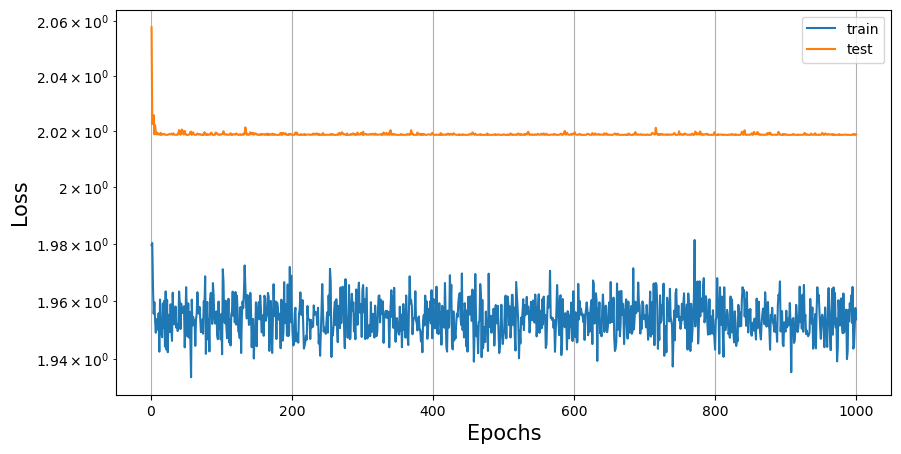

In [428]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_history["train"], label="train")
plt.plot(range(1, num_epochs + 1), loss_history["test"], label="test")
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.legend()
plt.grid()
plt.semilogy()
plt.show()

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future ver

1.4210410001792912
190.89384245586885


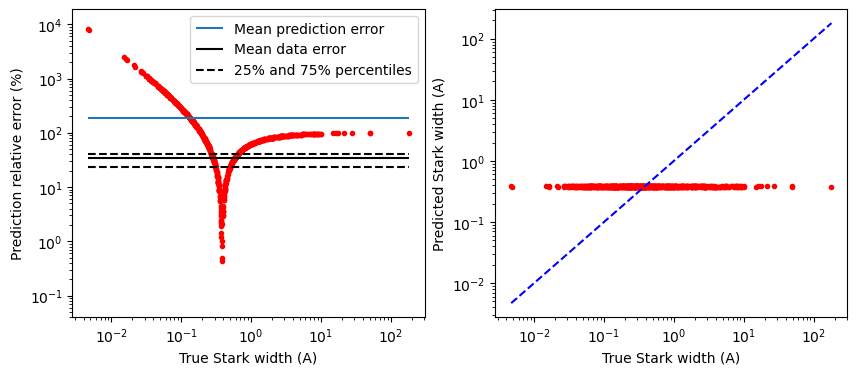

In [429]:
preds = model(torch.from_numpy(scaler.transform(X_test).astype(np.float32))).detach().numpy()

print(mean_squared_error(Y_test, preds, squared = False))
MREs = (np.abs(unscale(Y_test) - unscale(preds.reshape(preds.shape[0]))) / unscale(Y_test))*100
print(MREs.mean())

fig, ax = plt.subplots(1, 2, figsize = (10, 4))
ax[0].plot(unscale(Y_test), MREs, 'r.')
ax[0].hlines(MREs.mean(), np.amin(unscale(Y_test)), np.amax(unscale(Y_test)), label = 'Mean prediction error')
ax[0].hlines(34.438211, np.amin(unscale(Y_test)), np.amax(unscale(Y_test)), ls = '-', color = 'k', label = 'Mean data error')
ax[0].hlines(23., np.amin(unscale(Y_test)), np.amax(unscale(Y_test)), ls = '--', color = 'k', label = '25% and 75% percentiles')
ax[0].hlines(40., np.amin(unscale(Y_test)), np.amax(unscale(Y_test)), ls = '--', color = 'k')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend()
ax[0].set_xlabel('True Stark width (A)')
ax[0].set_ylabel('Prediction relative error (%)')
ax[0].set_ylim(4e-2, 1.9e4)

ax[1].plot(unscale(Y_test), unscale(preds.reshape(preds.shape[0])), 'r.')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].plot([np.amin(unscale(Y_test)), np.amax(unscale(Y_test))],
           [np.amin(unscale(Y_test)), np.amax(unscale(Y_test))], color = 'b', ls = '--')
ax[1].set_xlabel('True Stark width (A)')
ax[1].set_ylabel('Predicted Stark width (A)')
plt.savefig(f'XGB E_raw Raw No Test predictions.svg', transparent = True, format = 'svg')
plt.show()

In [406]:
class Simple_NN(nn.Module):
    
    def __init__(self):
        super(Simple_NN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features = 63,
                     out_features = 512),
            nn.Dropout(0.5),
            nn.ReLU(),
            
            nn.Linear(in_features = 512,
                     out_features = 128),
            nn.ReLU(),
            
            nn.Linear(in_features = 128,
                     out_features = 32),
            nn.Dropout(0.5),
            nn.ReLU(),
            
            nn.Linear(in_features = 32,
                     out_features = 8),
            nn.ReLU(),
        
            nn.Linear(in_features = 8,
                     out_features = 1),
            nn.ReLU())
        
        
    def forward(self, x):
        x = self.net(x)
        return x

In [17]:
def plot_model_prediction(models, X_train, y_train, X_test, y_test, X_elem = None, y_elem = None, label_elem = None,
                          plot = True):
    '''
    Takes models (dict) and data as input, returns predictions and plots
    '''
    if X_elem is None and y_elem is None:
        grid_h = 1
    elif X_elem is not None and y_elem is not None:
        grid_h = 2
    else:
        raise ValueError(f"'X_elem' and 'y_elem' must be both either 'None' or not.")
        
    predictions = {}
    predictions_elem = {}
    R2 = {}
    R2_elem = {}
    RMSE = {}
    RMSE_elem = {}
    MRE = {}
    MRE_elem = {}
    
    for name, model in models.items():
        if 'TabNet' in name:
            model.fit(X_train, y_train, X_test, y_test)
        else:
            model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        predictions[name] = y_pred
        if plot:
            R2[name] = r2_score(y_test, y_pred)
            RMSE[name] = mean_squared_error(y_test, y_pred, squared = False)
            MRE[name] = (np.abs(y_test - y_pred.reshape(y_pred.shape[0])) / y_test).mean()

        if grid_h == 2:
            y_pred = model.predict(X_elem)
            predictions_elem[name] = y_pred.flatten()
            
            if plot:
                R2_elem[name] = r2_score(y_elem, y_pred)
                RMSE_elem[name] = mean_squared_error(y_elem, y_pred, squared = False)
                MRE_elem[name] = (np.abs(y_elem - y_pred.reshape(y_pred.shape[0])) / y_elem).mean()
        
    if plot == True:
        i = 0
        fig, ax = plt.subplots(grid_h, len(models), figsize = (5*len(models), 4*grid_h))
        for name, model in models.items():
            print(f'Plotting {name} predictions')
            if grid_h == 1:
                ax[i].plot(y_test, predictions[name], 'r.')
                ax[i].plot([0, np.amax(y_test)], [0, np.amax(y_test)], color = 'b', ls = '--')
                ax[i].set_title(f'{name}')
                ax[i].text(x = 0, y = 1, s = f'$R^2$ = {R2[name]:.4f}', transform = ax[i].transAxes)
            else:
                ax[0, i].plot(y_test, predictions[name], 'r.')
                ax[0, i].plot([0, np.amax(y_test)], [0, np.amax(y_test)], color = 'b', ls = '--')
                ax[0, i].set_title(f'{name}')
                ax[0, i].text(x = 0, y = 1.02, s = f'$R^2$ = {R2[name]:.4f}  \nRMSE = {RMSE[name]:.4f}',  transform = ax[0, i].transAxes)

                #ax[1, i].plot(y_elem, predictions_elem[name], 'r.')
                sns.scatterplot(x = y_elem, y = predictions_elem[name], ax = ax[1, i], style = label_elem['Element'], hue = label_elem['Element'])
                ax[1, i].plot([0, np.amax(y_elem)], [0, np.amax(y_elem)], color = 'b', ls = '--')
                ax[1, i].text(x = 0, y = 1.01, s = f'$R^2$ = {R2_elem[name]:.4f}    RMSE = {RMSE_elem[name]:.4f}',  transform = ax[1, i].transAxes)
            i += 1
        plt.show()
        return predictions, predictions_elem, fig, ax
    
    else:
        return predictions, predictions_elem

# Ensemble of models

In [369]:
models = [
       'RF_Shift_Enorm_Raw_Scaler',
       'RF_Shift_Enorm_Aug_Scaler',
       'RF_Shift_Enorm_Aug_No',
      'KNN_Shift_Eraw_Raw_No',
 'CatBoost_Shift_Enorm_Raw_Scaler',
      'XGB_Shift_Enorm_Aug_No',
 'CatBoost_Shift_Enorm_Aug_No',
      'XGB_Shift_Enorm_Aug_Scaler',
       'RF_Shift_Enorm_Raw_No',
      'XGB_Shift_Enorm_Raw_Scaler',
      'XGB_Shift_Eraw_Aug_Scaler',
      'KNN_Shift_Enorm_Aug_Scaler',
      'KNN_Shift_Eraw_Aug_No',
 'CatBoost_Shift_Enorm_Aug_Scaler',
 'CatBoost_Shift_Enorm_Raw_No',
 'LightGBM_Shift_Enorm_Aug_Scaler',
            ]

# parameter = 'width'
# augmented_train_set = False
# normalized_energy = False
# X_train, Y_train, X_test, Y_test, X_elem, Y_elem, L_elem, scaler = constr_train_test(parameter,
#                                                                                          augmented_train_set,
#                                                                                          scaled_target=True,
#                                                                                          normalized_energy = normalized_energy,
#                                                                                          print_stats = False)

glob_path = 'C:\\Users\\Alex\\Documents\\GitHub'
models_d     = {}
preds_d      = {}
preds_elem_d = {}

for item in tqdm(models):
    if '_A+I_' in item:
        parameter = 'width'
    elif '_Shift_' in item:
        parameter = 'shift'
    else:
        raise NameError(f"Parameter for prediction must be specified in model's name: {item}")
    
    if 'KNN' in item:
        path = glob_path + '\\KNN'
    elif 'RF' in item:
        path = glob_path + '\\RF'
    elif 'XGB' in item:
        path = glob_path + '\\XGB'
    elif 'LightGBM' in item:
        path = glob_path + '\\LightGBM'
    elif 'CatBoost' in item:
        path = glob_path + '\\CatBoost'
    
    models_d_item = create_models_dict([item], path = path)
    models_d = models_d | models_d_item
    
    if '_Eraw_' in item:
        normalized_energy = False
    elif '_Enorm' in item:
        normalized_energy = True
    
    if '_Raw_' in item:
        augmented_train_set = False
    elif '_Aug_' in item:
        augmented_train_set = True
    
    if '_No' in item:
        apply_scaler = False
    elif '_Scaler' in item:
        apply_scaler = True
        
    X_train, Y_train, X_test, Y_test, X_elem, Y_elem, L_elem, scaler = constr_train_test(parameter,
                                                                                         augmented_train_set,
                                                                                         scaled_target=False,
                                                                                         normalized_energy = normalized_energy,
                                                                                         print_stats = False)
    
    if apply_scaler:
        preds, preds_elem = plot_model_prediction(models_d_item,
                                                  scaler.transform(X_train), Y_train,
                                                  scaler.transform(X_test), Y_test,
                                                  scaler.transform(X_elem), Y_elem, L_elem, 
                                                  plot = False)
    else:
        preds, preds_elem = plot_model_prediction(models_d_item,
                                                  X_train, Y_train,
                                                  X_test, Y_test,
                                                  X_elem, Y_elem, L_elem, 
                                                  plot = False)

        
    print(item)
#     print(mean_squared_error(Y_test, preds[item], squared = False))
#     MREs = (np.abs(unscale(Y_test) - unscale(preds[item])) / unscale(Y_test))*100
#     print(MREs.mean())

#     fig, ax = plt.subplots(1, 2, figsize = (10, 4))
#     ax[0].plot(unscale(Y_test), MREs, 'r.')
#     ax[0].hlines(MREs.mean(), np.amin(unscale(Y_test)), np.amax(unscale(Y_test)), label = 'Mean prediction error')
#     ax[0].hlines(34.438211, np.amin(unscale(Y_test)), np.amax(unscale(Y_test)), ls = '-', color = 'k', label = 'Mean data error')
#     ax[0].hlines(23., np.amin(unscale(Y_test)), np.amax(unscale(Y_test)), ls = '--', color = 'k', label = '25% and 75% percentiles')
#     ax[0].hlines(40., np.amin(unscale(Y_test)), np.amax(unscale(Y_test)), ls = '--', color = 'k')
#     ax[0].set_yscale('log')
#     ax[0].set_xscale('log')
#     ax[0].legend()
#     ax[0].set_xlabel('True Stark width (A)')
#     ax[0].set_ylabel('Prediction relative error (%)')
#     ax[1].plot(unscale(Y_test), unscale(preds[item]), 'r.')
#     ax[1].set_yscale('log')
#     ax[1].set_xscale('log')
#     ax[1].plot([np.amin(unscale(Y_test)), np.amax(unscale(Y_test))],
#                [np.amin(unscale(Y_test)), np.amax(unscale(Y_test))], color = 'b', ls = '--')
#     ax[1].set_xlabel('True Stark width (A)')
#     ax[1].set_ylabel('Predicted Stark width (A)')
#     plt.show()

    
    
#     print(mean_squared_error(Y_elem, preds_elem[item], squared = False))
#     MREs = (np.abs(unscale(Y_elem) - unscale(preds_elem[item])) / unscale(Y_elem))*100
#     print(MREs.mean())

#     fig, ax = plt.subplots(1, 2, figsize = (10, 4))
#     ax[0].plot(unscale(Y_elem), MREs, 'r.')
#     ax[0].hlines(MREs.mean(), np.amin(unscale(Y_elem)), np.amax(unscale(Y_elem)), label = 'Mean prediction error')
#     ax[0].hlines(34.438211, np.amin(unscale(Y_elem)), np.amax(unscale(Y_elem)), ls = '-', color = 'k', label = 'Mean data error')
#     ax[0].hlines(23., np.amin(unscale(Y_elem)), np.amax(unscale(Y_elem)), ls = '--', color = 'k', label = '25% and 75% percentiles')
#     ax[0].hlines(40., np.amin(unscale(Y_elem)), np.amax(unscale(Y_elem)), ls = '--', color = 'k')
#     ax[0].set_yscale('log')
#     ax[0].set_xscale('log')
#     ax[0].legend()
#     ax[0].set_xlabel('True Stark width (A)')
#     ax[0].set_ylabel('Prediction relative error (%)')
#     ax[1].plot(unscale(Y_elem), unscale(preds_elem[item]), 'r.')
#     ax[1].set_yscale('log')
#     ax[1].set_xscale('log')
#     ax[1].plot([np.amin(unscale(Y_elem)), np.amax(unscale(Y_elem))],
#                [np.amin(unscale(Y_elem)), np.amax(unscale(Y_elem))], color = 'b', ls = '--')
#     ax[1].set_xlabel('True Stark width (A)')
#     ax[1].set_ylabel('Predicted Stark width (A)')
#     plt.show()
    
    
    preds_d = preds_d | preds
    preds_elem_d = preds_elem_d | preds_elem

  6%|▋         | 1/16 [00:35<08:45, 35.03s/it]

RF_Shift_Enorm_Raw_Scaler


 12%|█▎        | 2/16 [03:37<28:27, 121.99s/it]

RF_Shift_Enorm_Aug_Scaler


 25%|██▌       | 4/16 [09:39<28:01, 140.11s/it]

RF_Shift_Enorm_Aug_No
KNN_Shift_Eraw_Raw_No


 31%|███▏      | 5/16 [09:45<16:46, 91.54s/it] 

CatBoost_Shift_Enorm_Raw_Scaler


 38%|███▊      | 6/16 [09:58<10:49, 64.96s/it]

XGB_Shift_Enorm_Aug_No


 44%|████▍     | 7/16 [10:12<07:14, 48.28s/it]

CatBoost_Shift_Enorm_Aug_No


 50%|█████     | 8/16 [10:25<04:55, 36.94s/it]

XGB_Shift_Enorm_Aug_Scaler


 56%|█████▋    | 9/16 [11:19<04:57, 42.51s/it]

RF_Shift_Enorm_Raw_No


 62%|██████▎   | 10/16 [11:22<03:01, 30.31s/it]

XGB_Shift_Enorm_Raw_Scaler


 69%|██████▉   | 11/16 [11:26<01:51, 22.28s/it]

XGB_Shift_Eraw_Aug_Scaler


 75%|███████▌  | 12/16 [11:39<01:17, 19.44s/it]

KNN_Shift_Enorm_Aug_Scaler


 81%|████████▏ | 13/16 [11:43<00:44, 14.82s/it]

KNN_Shift_Eraw_Aug_No


 88%|████████▊ | 14/16 [11:57<00:29, 14.52s/it]

CatBoost_Shift_Enorm_Aug_Scaler


 94%|█████████▍| 15/16 [12:01<00:11, 11.30s/it]

CatBoost_Shift_Enorm_Raw_No


100%|██████████| 16/16 [12:14<00:00, 45.93s/it]

LightGBM_Shift_Enorm_Aug_Scaler


In [412]:
preds_d

{'RF_Shift_Enorm_Raw_Scaler': array([-9.43253012e-02, -3.07987100e-02,  4.70932703e-02, -9.54704446e-02,
        -2.08858370e-02, -3.41746988e-01, -3.15394913e-02, -9.04064403e-02,
        -1.97399857e+00, -3.42053930e-02,  9.04599579e-03, -7.94037663e-01,
        -4.23591341e-02, -6.88903614e-02, -1.85198295e-02, -2.95103809e-01,
        -6.03204241e-02, -7.07893869e-02,  2.92443206e-02, -1.44216867e-01,
        -3.93500669e-02, -1.40355607e+00, -2.83292519e-02, -6.31643240e-02,
         5.68431851e-02, -8.01725082e-01, -5.27751004e-02, -9.00107368e-02,
        -5.92918380e-01, -1.18788147e-02, -2.56403921e-02, -3.48985966e-02,
        -1.25597627e-01, -6.08077793e-03, -3.14094259e-02, -3.50398640e-02,
        -6.19452247e-02, -2.60511304e-02, -5.38639891e-03, -1.32088353e-01,
        -4.31880857e-02, -3.05966729e-02,  2.80393240e-03, -2.72464032e-02,
        -2.65268434e-01, -6.61746988e-02, -2.39607980e-01, -2.24726616e-01,
        -3.48982597e-02, -3.39438126e-02, -1.33164927e-01, 

In [428]:
preds_d

{'RF_Shift_Enorm_Raw_Scaler': array([-9.43253012e-02, -3.07987100e-02,  4.70932703e-02, -9.54704446e-02,
        -2.08858370e-02, -3.41746988e-01, -3.15394913e-02, -9.04064403e-02,
        -1.97399857e+00, -3.42053930e-02,  9.04599579e-03, -7.94037663e-01,
        -4.23591341e-02, -6.88903614e-02, -1.85198295e-02, -2.95103809e-01,
        -6.03204241e-02, -7.07893869e-02,  2.92443206e-02, -1.44216867e-01,
        -3.93500669e-02, -1.40355607e+00, -2.83292519e-02, -6.31643240e-02,
         5.68431851e-02, -8.01725082e-01, -5.27751004e-02, -9.00107368e-02,
        -5.92918380e-01, -1.18788147e-02, -2.56403921e-02, -3.48985966e-02,
        -1.25597627e-01, -6.08077793e-03, -3.14094259e-02, -3.50398640e-02,
        -6.19452247e-02, -2.60511304e-02, -5.38639891e-03, -1.32088353e-01,
        -4.31880857e-02, -3.05966729e-02,  2.80393240e-03, -2.72464032e-02,
        -2.65268434e-01, -6.61746988e-02, -2.39607980e-01, -2.24726616e-01,
        -3.48982597e-02, -3.39438126e-02, -1.33164927e-01, 

In [437]:
RMSEs = {}
MREs  = {}
RMSEs_elem = {}
MREs_elem  = {}

RMSE_thresh      = 0.5441
MRE_thresh       = 64.29
RMSE_elem_thresh = 0.6828
MRE_elem_thresh  = 232.43

for idx1 in range(len(models)):
    md1 = models[idx1]
    pred = preds_d[md1].copy()
    pred_elem = preds_elem_d[md1].copy()
    
    for idx2 in range(idx1+1, len(models)):
        md2 = models[idx2]
        pred += preds_d[md2].copy()
        pred_elem += preds_elem_d[md2].copy()
        
        pred /= 2
        pred_elem /= 2

        RMSE = root_mean_squared_error(Y_test, pred)
        MRE = ((np.abs(Y_test - pred) / np.abs(Y_test))*100).replace(np.inf, np.nan).mean()
        RMSE_elem = root_mean_squared_error(Y_elem, pred_elem)
        MRE_elem = ((np.abs(Y_elem - pred_elem) / np.abs(Y_elem))*100).replace(np.inf, np.nan).mean()

        res = [RMSE <= RMSE_thresh, MRE <= MRE_thresh, RMSE_elem <= RMSE_elem_thresh, MRE_elem <= MRE_elem_thresh]

        if res.count(True) >= 1:
            print(res, md1, md2, md3)

[False, False, True, False] RF_Shift_Enorm_Raw_Scaler KNN_Shift_Eraw_Raw_No LightGBM_Shift_Enorm_Aug_Scaler
[False, False, True, False] RF_Shift_Enorm_Raw_Scaler XGB_Shift_Eraw_Aug_Scaler LightGBM_Shift_Enorm_Aug_Scaler
[False, False, True, False] RF_Shift_Enorm_Aug_Scaler KNN_Shift_Eraw_Raw_No LightGBM_Shift_Enorm_Aug_Scaler
[False, False, True, False] RF_Shift_Enorm_Aug_Scaler XGB_Shift_Eraw_Aug_Scaler LightGBM_Shift_Enorm_Aug_Scaler
[False, False, True, False] RF_Shift_Enorm_Aug_No KNN_Shift_Eraw_Raw_No LightGBM_Shift_Enorm_Aug_Scaler
[False, False, True, False] RF_Shift_Enorm_Aug_No XGB_Shift_Eraw_Aug_Scaler LightGBM_Shift_Enorm_Aug_Scaler
[False, False, True, False] KNN_Shift_Eraw_Raw_No CatBoost_Shift_Enorm_Raw_Scaler LightGBM_Shift_Enorm_Aug_Scaler
[False, False, True, False] KNN_Shift_Eraw_Raw_No XGB_Shift_Enorm_Aug_No LightGBM_Shift_Enorm_Aug_Scaler
[False, False, True, False] KNN_Shift_Eraw_Raw_No XGB_Shift_Eraw_Aug_Scaler LightGBM_Shift_Enorm_Aug_Scaler
[False, False, True, 

In [327]:
MREs.replace(np.inf, np.nan).mean()

89.07544479172763

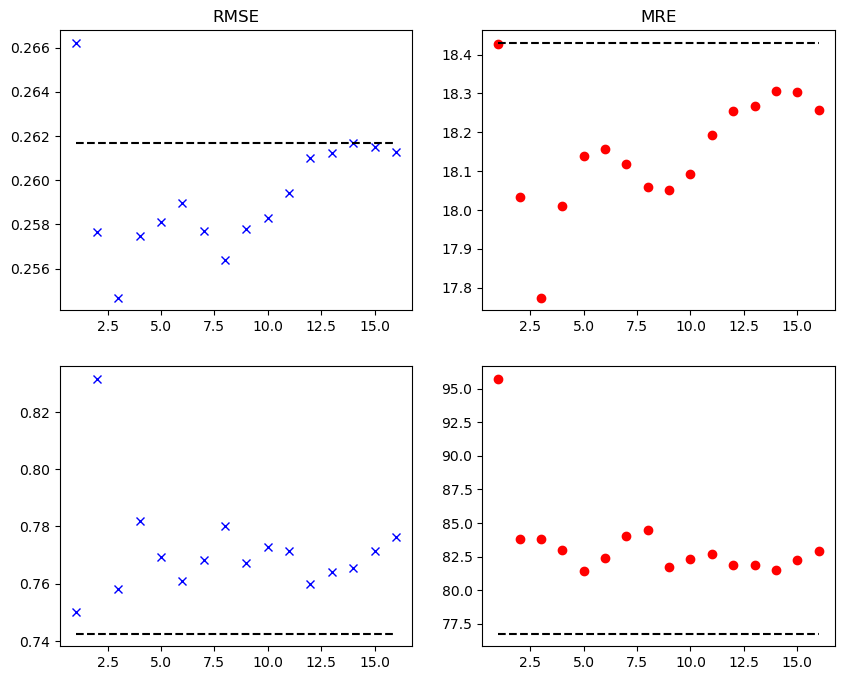

In [33]:
RMSEs = {}
MREs  = {}
RMSEs_elem = {}
MREs_elem  = {}
pred = preds_d[models[0]]
pred_elem = preds_elem_d[models[0]]

for i in range(1, len(models)+1):
    pred = np.zeros(preds_d[models[0]].shape)
    pred_elem = np.zeros(preds_elem_d[models[0]].shape)
    for j in range(i):
        model = models[j]
        pred += preds_d[model]
        pred_elem += preds_elem_d[model]
    pred /= i
    pred_elem /= i
    RMSEs[i] = root_mean_squared_error(Y_test, pred)
    MREs[i]  = ((np.abs(unscale(Y_test) - unscale(pred)) / unscale(Y_test))*100).mean()
    RMSEs_elem[i] = root_mean_squared_error(Y_elem, pred_elem)
    MREs_elem[i]  = ((np.abs(unscale(Y_elem) - unscale(pred_elem)) / unscale(Y_elem))*100).mean()

fig, ax = plt.subplots(2, 2, figsize = (10, 8))
# twinax = 
ax[0,1].plot(MREs.keys(), MREs.values(), 'ro')
ax[0,0].plot(RMSEs.keys(), RMSEs.values(), 'bx')
ax[0,1].set_title('MRE')
ax[0,0].set_title('RMSE')

ax[1,1].plot(MREs_elem.keys(), MREs_elem.values(), 'ro')
ax[1,0].plot(RMSEs_elem.keys(), RMSEs_elem.values(), 'bx')

ax[0, 0].hlines(0.2617, 1, 16, color = 'k', ls = '--')
ax[0, 1].hlines(18.43, 1, 16, color = 'k', ls = '--')
ax[1, 0].hlines(0.7426, 1, 16, color = 'k', ls = '--')
ax[1, 1].hlines(76.78, 1, 16, color = 'k', ls = '--')
plt.show()

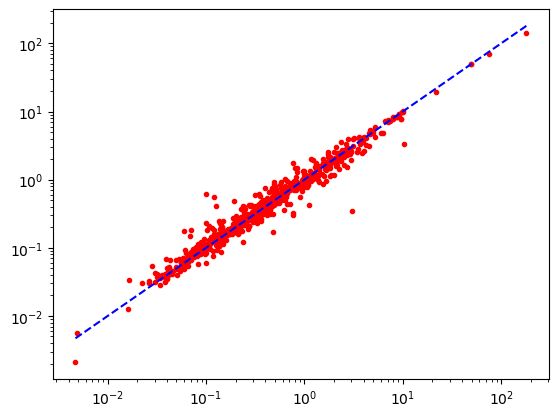

In [34]:
fig, ax = plt.subplots()
ax.plot(unscale(Y_test), unscale(pred), 'r.')
ax.plot([np.amin(unscale(Y_test)), np.amax(unscale(Y_test))],
         [np.amin(unscale(Y_test)), np.amax(unscale(Y_test))], 
        color = 'b', ls = '--')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

In [136]:
from tqdm.notebook import tqdm
models = [
       'XGB_A+I_Eraw_Raw_No',
            'LightGBM_A+I_Eraw_Raw_Scaler',
       'CatBoost_A+I_Enorm_Raw_No',
            'XGB_A+I_Eraw_Raw_Scaler',
             'LightGBM_A+I_Enorm_Raw_Scaler',
             'CatBoost_A+I_Enorm_Raw_Scaler',
             'CatBoost_A+I_Eraw_Raw_No',
             'LightGBM_A+I_Eraw_Raw_No',
             'XGB_A+I_Enorm_Aug_No',
             'XGB_A+I_Enorm_Raw_Scaler',
             'LightGBM_A+I_Enorm_Raw_No',
             'CatBoost_A+I_Enorm_Aug_Scaler',
             'RF_A+I_Eraw_Raw_Scaler',
             'RF_A+I_Eraw_Raw_No',
             'XGB_A+I_Enorm_Raw_No',
             'CatBoost_A+I_Eraw_Aug_No',
            ]

quints = [
    ['XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No', 'LightGBM_A+I_Enorm_Raw_Scaler', 'LightGBM_A+I_Eraw_Raw_No', 'XGB_A+I_Enorm_Aug_No'],
    ['XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No', 'LightGBM_A+I_Enorm_Raw_Scaler', 'LightGBM_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_Scaler'],
    ['XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No', 'CatBoost_A+I_Eraw_Raw_No', 'XGB_A+I_Enorm_Aug_No', 'LightGBM_A+I_Enorm_Raw_Scaler'],
    ['XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No', 'LightGBM_A+I_Enorm_Raw_Scaler', 'CatBoost_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_Scaler'],
    ['XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No', 'LightGBM_A+I_Enorm_Raw_Scaler', 'LightGBM_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Aug_Scaler'],
]

RMSE_thresh      = 0.2617
MRE_thresh       = 18.43
RMSE_elem_thresh = 0.7426
MRE_elem_thresh  = 76.78

for quint in tqdm(quints):
    for md6 in tqdm(models):
        if md6 in quint:
            continue
        ensemble = quint.copy()
        ensemble.append(md6)
#         print(ensemble)
        preds_d, preds_elem_d = train_ensemble(ensemble)
        pred = np.zeros(preds_d[ensemble[0]].shape)
        pred_elem = np.zeros(preds_elem_d[ensemble[0]].shape)
        for i in ensemble:
            pred += preds_d[i]
            pred_elem += preds_elem_d[i]
#           print(pred)
        pred /= len(ensemble)
        pred_elem /= len(ensemble)

        RMSE = root_mean_squared_error(Y_test, pred)
        MRE = ((np.abs(unscale(Y_test) - unscale(pred)) / unscale(Y_test))*100).mean()
        RMSE_elem = root_mean_squared_error(Y_elem, pred_elem)
        MRE_elem = ((np.abs(unscale(Y_elem) - unscale(pred_elem)) / unscale(Y_elem))*100).mean()

        res = [RMSE <= RMSE_thresh, MRE <= MRE_thresh, RMSE_elem <= RMSE_elem_thresh, MRE_elem <= MRE_elem_thresh]

        if res.count(True) >= 3:
            print(ensemble)

send_email("All sixtets of models tested. Come check results!")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

['XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No', 'LightGBM_A+I_Enorm_Raw_Scaler', 'LightGBM_A+I_Eraw_Raw_No', 'XGB_A+I_Enorm_Aug_No', 'CatBoost_A+I_Enorm_Raw_Scaler']
['XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No', 'LightGBM_A+I_Enorm_Raw_Scaler', 'LightGBM_A+I_Eraw_Raw_No', 'XGB_A+I_Enorm_Aug_No', 'CatBoost_A+I_Eraw_Raw_No']
['XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No', 'LightGBM_A+I_Enorm_Raw_Scaler', 'LightGBM_A+I_Eraw_Raw_No', 'XGB_A+I_Enorm_Aug_No', 'RF_A+I_Eraw_Raw_Scaler']
['XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No', 'LightGBM_A+I_Enorm_Raw_Scaler', 'LightGBM_A+I_Eraw_Raw_No', 'XGB_A+I_Enorm_Aug_No', 'RF_A+I_Eraw_Raw_No']


  0%|          | 0/16 [00:00<?, ?it/s]

['XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No', 'LightGBM_A+I_Enorm_Raw_Scaler', 'LightGBM_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_Scaler', 'XGB_A+I_Enorm_Aug_No']
['XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No', 'LightGBM_A+I_Enorm_Raw_Scaler', 'LightGBM_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_Scaler', 'LightGBM_A+I_Enorm_Raw_No']


  0%|          | 0/16 [00:00<?, ?it/s]

['XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No', 'CatBoost_A+I_Eraw_Raw_No', 'XGB_A+I_Enorm_Aug_No', 'LightGBM_A+I_Enorm_Raw_Scaler', 'XGB_A+I_Eraw_Raw_Scaler']
['XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No', 'CatBoost_A+I_Eraw_Raw_No', 'XGB_A+I_Enorm_Aug_No', 'LightGBM_A+I_Enorm_Raw_Scaler', 'CatBoost_A+I_Enorm_Raw_Scaler']
['XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No', 'CatBoost_A+I_Eraw_Raw_No', 'XGB_A+I_Enorm_Aug_No', 'LightGBM_A+I_Enorm_Raw_Scaler', 'LightGBM_A+I_Eraw_Raw_No']
['XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No', 'CatBoost_A+I_Eraw_Raw_No', 'XGB_A+I_Enorm_Aug_No', 'LightGBM_A+I_Enorm_Raw_Scaler', 'RF_A+I_Eraw_Raw_Scaler']


  0%|          | 0/16 [00:00<?, ?it/s]

['XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No', 'LightGBM_A+I_Enorm_Raw_Scaler', 'CatBoost_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_Scaler', 'XGB_A+I_Enorm_Aug_No']
['XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No', 'LightGBM_A+I_Enorm_Raw_Scaler', 'CatBoost_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_Scaler', 'LightGBM_A+I_Enorm_Raw_No']


  0%|          | 0/16 [00:00<?, ?it/s]

['XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No', 'LightGBM_A+I_Enorm_Raw_Scaler', 'LightGBM_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Aug_Scaler', 'CatBoost_A+I_Eraw_Raw_No']
['XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No', 'LightGBM_A+I_Enorm_Raw_Scaler', 'LightGBM_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Aug_Scaler', 'XGB_A+I_Enorm_Raw_Scaler']
['XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No', 'LightGBM_A+I_Enorm_Raw_Scaler', 'LightGBM_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Aug_Scaler', 'XGB_A+I_Enorm_Raw_No']
['XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No', 'LightGBM_A+I_Enorm_Raw_Scaler', 'LightGBM_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Aug_Scaler', 'CatBoost_A+I_Eraw_Aug_No']


In [161]:
models = [
        'XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No', 'LightGBM_A+I_Enorm_Raw_Scaler', 'LightGBM_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Aug_Scaler', 'CatBoost_A+I_Eraw_Aug_No'
            ]

# parameter = 'width'
# augmented_train_set = False
# normalized_energy = False
# X_train, Y_train, X_test, Y_test, X_elem, Y_elem, L_elem, scaler = constr_train_test(parameter,
#                                                                                          augmented_train_set,
#                                                                                          scaled_target=True,
#                                                                                          normalized_energy = normalized_energy,
#                                                                                          print_stats = False)

glob_path = 'C:\\Users\\Alex\\Documents\\GitHub'
models_d     = {}
preds_d      = {}
preds_elem_d = {}

for item in models:
    if '_A+I_' in item:
        parameter = 'width'
    elif '_Shift_' in item:
        parameter = 'shift'
    else:
        raise NameError(f"Parameter for prediction must be specified in model's name: {item}")
    
    if 'KNN' in item:
        path = glob_path + '\\KNN'
    elif 'RF' in item:
        path = glob_path + '\\RF'
    elif 'XGB' in item:
        path = glob_path + '\\XGB'
    elif 'LightGBM' in item:
        path = glob_path + '\\LightGBM'
    elif 'CatBoost' in item:
        path = glob_path + '\\CatBoost'
    
    models_d_item = create_models_dict([item], path = path)
    models_d = models_d | models_d_item
    
    if '_Eraw_' in item:
        normalized_energy = False
    elif '_Enorm' in item:
        normalized_energy = True
    
    if '_Raw_' in item:
        augmented_train_set = False
    elif '_Aug_' in item:
        augmented_train_set = True
    
    if '_No' in item:
        apply_scaler = False
    elif '_Scaler' in item:
        apply_scaler = True
        
    X_train, Y_train, X_test, Y_test, X_elem, Y_elem, L_elem, scaler = constr_train_test(parameter,
                                                                                         augmented_train_set,
                                                                                         scaled_target=True,
                                                                                         normalized_energy = normalized_energy,
                                                                                         print_stats = False)
    
    if apply_scaler:
        preds, preds_elem = plot_model_prediction(models_d_item,
                                                  scaler.transform(X_train), Y_train,
                                                  scaler.transform(X_test), Y_test,
                                                  scaler.transform(X_elem), Y_elem, L_elem, 
                                                  plot = False)
    else:
        preds, preds_elem = plot_model_prediction(models_d_item,
                                                  X_train, Y_train,
                                                  X_test, Y_test,
                                                  X_elem, Y_elem, L_elem, 
                                                  plot = False)

    print(item)
    
    preds_d = preds_d | preds
    preds_elem_d = preds_elem_d | preds_elem

XGB_A+I_Eraw_Raw_No
CatBoost_A+I_Enorm_Raw_No
LightGBM_A+I_Enorm_Raw_Scaler
LightGBM_A+I_Eraw_Raw_No
CatBoost_A+I_Enorm_Aug_Scaler
CatBoost_A+I_Eraw_Aug_No


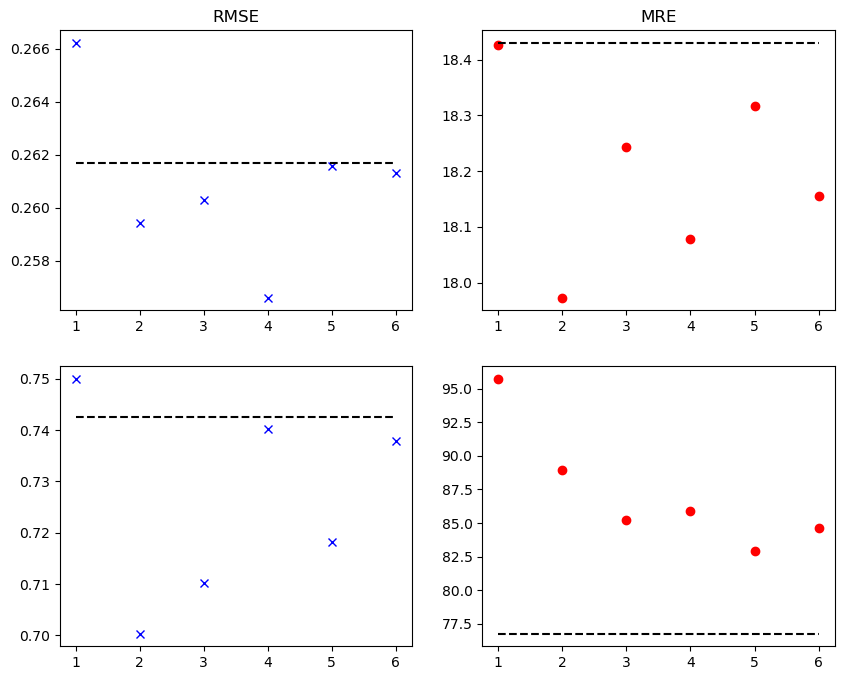

0.2612986650135337
18.155116598719694
0.7378774475756347
84.61672578417044


In [162]:
RMSEs = {}
MREs  = {}
RMSEs_elem = {}
MREs_elem  = {}
pred = preds_d[models[0]]
pred_elem = preds_elem_d[models[0]]

for i in range(1, len(models)+1):
    pred = np.zeros(preds_d[models[0]].shape)
    pred_elem = np.zeros(preds_elem_d[models[0]].shape)
    for j in range(i):
        model = models[j]
        pred += preds_d[model]
        pred_elem += preds_elem_d[model]
    pred /= i
    pred_elem /= i
    RMSEs[i] = root_mean_squared_error(Y_test, pred)
    MREs[i]  = ((np.abs(unscale(Y_test) - unscale(pred)) / unscale(Y_test))*100).mean()
    RMSEs_elem[i] = root_mean_squared_error(Y_elem, pred_elem)
    MREs_elem[i]  = ((np.abs(unscale(Y_elem) - unscale(pred_elem)) / unscale(Y_elem))*100).mean()

fig, ax = plt.subplots(2, 2, figsize = (10, 8))
# twinax = 
ax[0,1].plot(MREs.keys(), MREs.values(), 'ro')
ax[0,0].plot(RMSEs.keys(), RMSEs.values(), 'bx')
ax[0,1].set_title('MRE')
ax[0,0].set_title('RMSE')

ax[1,1].plot(MREs_elem.keys(), MREs_elem.values(), 'ro')
ax[1,0].plot(RMSEs_elem.keys(), RMSEs_elem.values(), 'bx')

ax[0, 0].hlines(0.2617, 1, len(preds_d), color = 'k', ls = '--')
ax[0, 1].hlines(18.43, 1, len(preds_d), color = 'k', ls = '--')
ax[1, 0].hlines(0.7426, 1, len(preds_d), color = 'k', ls = '--')
ax[1, 1].hlines(76.78, 1, len(preds_d), color = 'k', ls = '--')
plt.show()

print(RMSEs[6])
print(MREs[6])
print(RMSEs_elem[6])
print(MREs_elem[6])

In [56]:
import smtplib
def send_email(message):
    smtpObj = smtplib.SMTP('smtp.gmail.com', 587)
    smtpObj.starttls()
    smtpObj.login('alezakuskin2407@gmail.com','yaic qsvs nmwd iysf')
    smtpObj.sendmail("alezakuskin2407@gmail.com", 'ale-zakuskin@yandex.ru', message)
    smtpObj.quit()

## Genetic algorithm

In [206]:
pool_of_models = [
    'CatBoost_A+I_Enorm_Raw_No',
            'XGB_A+I_Eraw_Raw_No',
#        'LightGBM_A+I_Enorm_Raw_Scaler',
#             'XGB_A+I_Eraw_Raw_Scaler',
#             'XGB_A+I_Enorm_Raw_Scaler',
       'CatBoost_A+I_Eraw_Raw_No',
       'LightGBM_A+I_Eraw_Raw_Scaler',
            'XGB_A+I_Enorm_Aug_No',
            'CatBoost_A+I_Enorm_Raw_Scaler',
            'LightGBM_A+I_Eraw_Raw_No',
            'RF_A+I_Eraw_Raw_No',
            'CatBoost_A+I_Enorm_Aug_Scaler',
            'LightGBM_A+I_Enorm_Raw_No',
            'CatBoost_A+I_Eraw_Raw_Scaler',
            'XGB_A+I_Enorm_Raw_No',
            'CatBoost_A+I_Eraw_Aug_No',
]

np.random.seed(77)

parents = []
for i in range(5):
    parents.append(list(np.random.choice(pool_of_models, size = 2)))
parents[-1] = ['CatBoost_A+I_Enorm_Raw_No', 'XGB_A+I_Eraw_Raw_No']                        #cheating

    
RMSEs = {}
MREs  = {}
RMSEs_elem = {}
MREs_elem  = {}
for individual in parents:
    print(individual)
    preds_d, preds_elem_d = train_ensemble(individual)

    

    pred = np.zeros(preds_d[individual[0]].shape)
    pred_elem = np.zeros(preds_elem_d[individual[0]].shape)
    for key in preds_d.keys():
        pred += preds_d[key]
        pred_elem += preds_elem_d[key]
    pred /= len(preds_d.keys())
    pred_elem /= len(preds_d.keys())
    
    RMSEs[str(individual)] = root_mean_squared_error(Y_test, pred)
    MREs[str(individual)]  = ((np.abs(unscale(Y_test) - unscale(pred)) / unscale(Y_test))*100).mean()
    RMSEs_elem[str(individual)] = root_mean_squared_error(Y_elem, pred_elem)
    MREs_elem[str(individual)]  = ((np.abs(unscale(Y_elem) - unscale(pred_elem)) / unscale(Y_elem))*100).mean()

print(RMSEs)
print(MREs)
print(RMSEs_elem)
print(MREs_elem)

['RF_A+I_Eraw_Raw_No', 'XGB_A+I_Enorm_Aug_No']
['XGB_A+I_Enorm_Aug_No', 'XGB_A+I_Enorm_Raw_No']
['CatBoost_A+I_Enorm_Raw_Scaler', 'CatBoost_A+I_Enorm_Aug_Scaler']
['CatBoost_A+I_Enorm_Raw_No', 'LightGBM_A+I_Enorm_Raw_No']
['CatBoost_A+I_Enorm_Raw_No', 'XGB_A+I_Eraw_Raw_No']
{"['RF_A+I_Eraw_Raw_No', 'XGB_A+I_Enorm_Aug_No']": 0.28240519428141114, "['XGB_A+I_Enorm_Aug_No', 'XGB_A+I_Enorm_Raw_No']": 0.27677895982446526, "['CatBoost_A+I_Enorm_Raw_Scaler', 'CatBoost_A+I_Enorm_Aug_Scaler']": 0.28215183102182667, "['CatBoost_A+I_Enorm_Raw_No', 'LightGBM_A+I_Enorm_Raw_No']": 0.2688345232833455, "['CatBoost_A+I_Enorm_Raw_No', 'XGB_A+I_Eraw_Raw_No']": 0.25795668745247186}
{"['RF_A+I_Eraw_Raw_No', 'XGB_A+I_Enorm_Aug_No']": 19.600123946410786, "['XGB_A+I_Enorm_Aug_No', 'XGB_A+I_Enorm_Raw_No']": 19.38671632349324, "['CatBoost_A+I_Enorm_Raw_Scaler', 'CatBoost_A+I_Enorm_Aug_Scaler']": 19.71096670174337, "['CatBoost_A+I_Enorm_Raw_No', 'LightGBM_A+I_Enorm_Raw_No']": 18.95325942425045, "['CatBoost_A+I_En

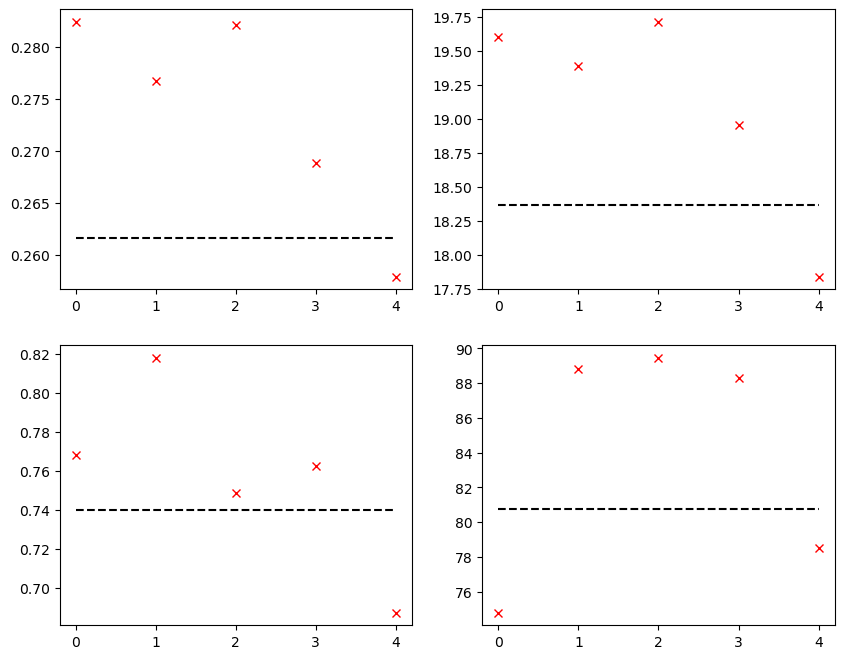

In [202]:
fig, ax = plt.subplots(2, 2, figsize = (10,8))
ax[0, 0].plot(RMSEs.values(), 'rx')
ax[0, 1].plot(MREs.values(), 'rx')
ax[1, 0].plot(RMSEs_elem.values(), 'rx')
ax[1, 1].plot(MREs_elem.values(), 'rx')

ax[0, 0].hlines(0.2617, 0, len(MREs)-1, color = 'k', ls = '--')
ax[0, 1].hlines(18.37, 0, len(MREs)-1, color = 'k', ls = '--')
ax[1, 0].hlines(0.7397, 0, len(MREs)-1, color = 'k', ls = '--')
ax[1, 1].hlines(80.76, 0, len(MREs)-1, color = 'k', ls = '--')

plt.show()

In [207]:
best_score = np.array(list(MREs.values())).min()*0.98
print(best_score)
sss = (1/(np.array(list(MREs.values()))-best_score)).sum()
print(sss)
probs = (1/(np.array(list(MREs.values()))-best_score))/sss*100
print(probs)

gen2 = []
for i in range(5):
    pair_of_parents = []
    idx_of_parents = np.random.choice(np.arange(len(parents)), size = 2, p = probs/100, replace = False)
    for idx in idx_of_parents:
#         print(idx)
        pair_of_parents.append(parents[idx])
#     print(pair_of_parents)
    child = [pair_of_parents[0][0], pair_of_parents[1][1]]
#     print(child)
    gen2.append(child)
print(gen2)

RMSEs = {}
MREs  = {}
RMSEs_elem = {}
MREs_elem  = {}
for individual in gen2:
    print(individual)
    preds_d, preds_elem_d = train_ensemble(individual)

    pred = np.zeros(preds_d[individual[0]].shape)
    pred_elem = np.zeros(preds_elem_d[individual[0]].shape)
    for key in preds_d.keys():
        pred += preds_d[key]
        pred_elem += preds_elem_d[key]
    pred /= len(preds_d.keys())
    pred_elem /= len(preds_d.keys())
    
    RMSEs[str(individual)] = root_mean_squared_error(Y_test, pred)
    MREs[str(individual)]  = ((np.abs(unscale(Y_test) - unscale(pred)) / unscale(Y_test))*100).mean()
    RMSEs_elem[str(individual)] = root_mean_squared_error(Y_elem, pred_elem)
    MREs_elem[str(individual)]  = ((np.abs(unscale(Y_elem) - unscale(pred_elem)) / unscale(Y_elem))*100).mean()

print(RMSEs)
print(MREs)
print(RMSEs_elem)
print(MREs_elem)

17.48532321092847
4.931674983351872
[ 9.58817827 10.66433149  9.11066239 13.8133294  56.82349844]
[['CatBoost_A+I_Enorm_Raw_No', 'XGB_A+I_Enorm_Raw_No'], ['CatBoost_A+I_Enorm_Raw_No', 'CatBoost_A+I_Enorm_Aug_Scaler'], ['CatBoost_A+I_Enorm_Raw_No', 'XGB_A+I_Enorm_Raw_No'], ['CatBoost_A+I_Enorm_Raw_No', 'LightGBM_A+I_Enorm_Raw_No'], ['CatBoost_A+I_Enorm_Raw_No', 'CatBoost_A+I_Enorm_Aug_Scaler']]
['CatBoost_A+I_Enorm_Raw_No', 'XGB_A+I_Enorm_Raw_No']
['CatBoost_A+I_Enorm_Raw_No', 'CatBoost_A+I_Enorm_Aug_Scaler']
['CatBoost_A+I_Enorm_Raw_No', 'XGB_A+I_Enorm_Raw_No']
['CatBoost_A+I_Enorm_Raw_No', 'LightGBM_A+I_Enorm_Raw_No']
['CatBoost_A+I_Enorm_Raw_No', 'CatBoost_A+I_Enorm_Aug_Scaler']
{"['CatBoost_A+I_Enorm_Raw_No', 'XGB_A+I_Enorm_Raw_No']": 0.2639947841170876, "['CatBoost_A+I_Enorm_Raw_No', 'CatBoost_A+I_Enorm_Aug_Scaler']": 0.2773651964123269, "['CatBoost_A+I_Enorm_Raw_No', 'LightGBM_A+I_Enorm_Raw_No']": 0.2688345232833455}
{"['CatBoost_A+I_Enorm_Raw_No', 'XGB_A+I_Enorm_Raw_No']": 18.690

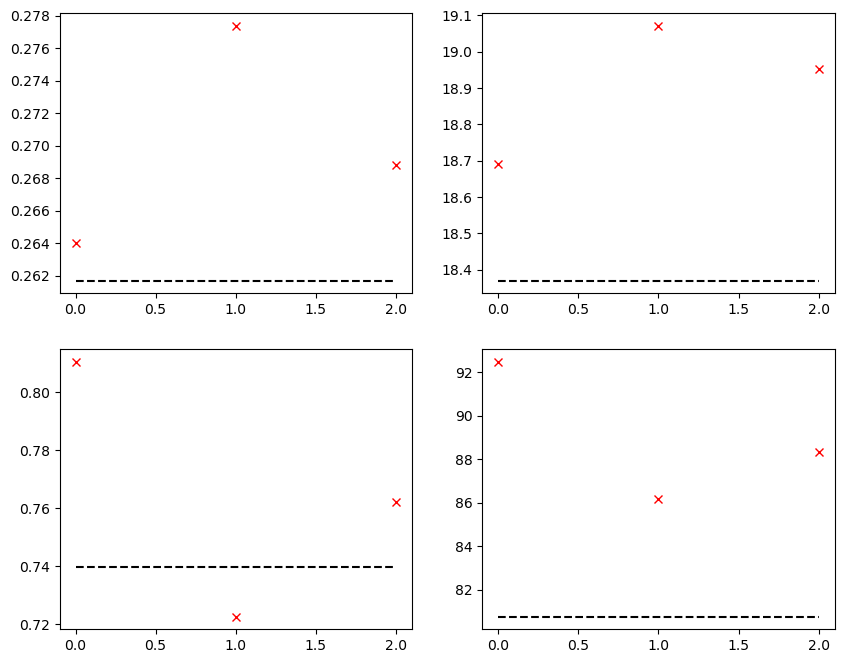

In [208]:
fig, ax = plt.subplots(2, 2, figsize = (10,8))
ax[0, 0].plot(RMSEs.values(), 'rx')
ax[0, 1].plot(MREs.values(), 'rx')
ax[1, 0].plot(RMSEs_elem.values(), 'rx')
ax[1, 1].plot(MREs_elem.values(), 'rx')

ax[0, 0].hlines(0.2617, 0, len(MREs)-1, color = 'k', ls = '--')
ax[0, 1].hlines(18.37, 0, len(MREs)-1, color = 'k', ls = '--')
ax[1, 0].hlines(0.7397, 0, len(MREs)-1, color = 'k', ls = '--')
ax[1, 1].hlines(80.76, 0, len(MREs)-1, color = 'k', ls = '--')

plt.show()

In [365]:
def train_ensemble(ensemble):
    glob_path = 'C:\\Users\\Alex\\Documents\\GitHub'
    models_d     = {}
    preds_d      = {}
    preds_elem_d = {}

    for item in ensemble:
        if '_A+I_' in item:
            parameter = 'width'
        elif '_Shift_' in item:
            parameter = 'shift'
        else:
            raise NameError(f"Parameter for prediction must be specified in model's name: {item}")

        if 'KNN' in item:
            path = glob_path + '\\KNN'
        elif 'RF' in item:
            path = glob_path + '\\RF'
        elif 'XGB' in item:
            path = glob_path + '\\XGB'
        elif 'LightGBM' in item:
            path = glob_path + '\\LightGBM'
        elif 'CatBoost' in item:
            path = glob_path + '\\CatBoost'

        models_d_item = create_models_dict([item], path = path)

        if '_Eraw_' in item:
            normalized_energy = False
        elif '_Enorm' in item:
            normalized_energy = True

        if '_Raw_' in item:
            augmented_train_set = False
        elif '_Aug_' in item:
            augmented_train_set = True

        if '_No' in item:
            apply_scaler = False
        elif '_Scaler' in item:
            apply_scaler = True

        X_train, Y_train, X_test, Y_test, X_elem, Y_elem, L_elem, scaler = constr_train_test(parameter,
                                                                                             augmented_train_set,
                                                                                             scaled_target=False,
                                                                                             normalized_energy = normalized_energy,
                                                                                             print_stats = False)

        if apply_scaler:
            preds, preds_elem = plot_model_prediction(models_d_item,
                                                      scaler.transform(X_train), Y_train,
                                                      scaler.transform(X_test), Y_test,
                                                      scaler.transform(X_elem), Y_elem, L_elem, 
                                                      plot = False)
        else:
            preds, preds_elem = plot_model_prediction(models_d_item,
                                                      X_train, Y_train,
                                                      X_test, Y_test,
                                                      X_elem, Y_elem, L_elem, 
                                                      plot = False)
        preds_d = preds_d | preds
        preds_elem_d = preds_elem_d | preds_elem
    
    return preds_d, preds_elem_d

# Models optimization

## CatBoost

In [ ]:
CatBoost_params = {
    'learning_rate' : [0.01, 1],
    'max_depth' : [2, 12],
    'l2_leaf_reg' : [0.5, 30],
    'min_data_in_leaf' : [6, 14],
    'random_strength' : [1, 4],
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : 2
    }

model_name = CatBoost

if apply_scaler:
    print('Scaling')
    CatBoost_res = main(X = pd.DataFrame(scaler.transform(X_train)), y = Y_train, model_name = model_name, params = CatBoost_params, n_trials = 100)
else:
    CatBoost_res = main(X = X_train, y = Y_train, model_name = model_name, params = CatBoost_params, n_trials = 100)

with open(f'CatBoost_Shift_Eraw_Raw_Scaler_optimal_parameters', 'w') as fp:
    json.dump(CatBoost_res.best_params, fp)

In [ ]:
optuna.visualization.plot_param_importances(CatBoost_res)

In [ ]:
optuna.visualization.plot_optimization_history(CatBoost_res)

## KNN

In [ ]:
KNN_params = {
    'n_neighbors' : [1, 150],
    'weights' : ['distance', 'uniform'],
    'leaf_size' : [1, 100],
    'p' : [1., 2.],
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : 2
    }

model_name = KNN

if apply_scaler:
    print('Scaling')
    KNN_res = main(X = pd.DataFrame(scaler.transform(X_train)), y = Y_train, model_name = model_name, params = KNN_params, n_trials = 100)
else:
    KNN_res = main(X = X_train, y = Y_train, model_name = model_name, params = KNN_params, n_trials = 100)

with open(f'KNN_Shift_Eraw_Raw_Scaler_optimal_parameters', 'w') as fp:
    json.dump(KNN_res.best_params, fp)

In [ ]:
#Compare default KNN vs optimised KNN
KNN_params = KNN_res.best_params

models = {}

models['new'] = KNeighborsRegressor(**KNN_params)
models['default'] = KNeighborsRegressor()

results = train_and_test_regressor(models, X_train, Y_train, X_test, Y_test)

plot_model_comparison(results)

In [ ]:
#Visualise importance of KNN model parameters
optuna.visualization.plot_param_importances(KNN_res)

In [ ]:
optuna.visualization.plot_slice(KNN_res, params = ['weights', 'n_neighbors'])

## Random Forest

In [ ]:
RF_params = {
    'n_estimators' : [10, 250],
    'max_depth' : [1, 80],
    'min_samples_split' : [2, 10],
    'min_samples_leaf' : [1, 10],
    'criterion' : ['squared_error', 'absolute_error'],      #add 'poisson' for width tuning
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : 4
    }

model_name = RandomForest

if apply_scaler:
    print('Scaling')
    RF_res = main(X = pd.DataFrame(scaler.transform(X_train)), y = Y_train, model_name = model_name, params = RF_params, n_trials = 100)
else:
    RF_res = main(X = X_train, y = Y_train, model_name = model_name, params = RF_params, n_trials = 100)

with open(f'RF_Shift_Enorm_Raw_Scaler_optimal_parameters', 'w') as fp:
    json.dump(RF_res.best_params, fp)

In [ ]:
RF_params

In [ ]:
#Compare default RandomForest vs optimised RandomForest
RF_params = RF_res.best_params

models_RF = {}

models_RF['new'] = RandomForestRegressor(**RF_params)
models_RF['default'] = RandomForestRegressor()

results_RF = train_and_test_regressor(models_RF, X_train, Y_train, X_test, Y_test)
plot_model_comparison(results_RF)

In [ ]:
#Visualising selection of n_estimators
model = {}
for i in range(10, 201, 10):
    model[f'{i}'] = RandomForestRegressor(**RF_params, n_estimators = i)

path = train_and_test_regressor(model, X_train, Y_train, X_test, Y_test)
plot_model_comparison(path)

In [ ]:
optuna.visualization.plot_param_importances(RF_res)

In [ ]:
#Visualising feature importances for the optimal RF model
feature_importance = models_RF['new'].feature_importances_
sorted = np.argsort(feature_importance)
pos = np.arange(sorted.shape[0]) + 0.5

plt.figure(figsize = (15, 15))
plt.barh(pos, feature_importance[sorted])
plt.yticks(pos, np.array(X_train.columns)[sorted])
plt.semilogx()
plt.show()

In [ ]:
optuna.visualization.plot_slice(RF_res, params = ['n_estimators', 'max_depth'])

In [ ]:
optuna.visualization.plot_optimization_history(RF_res)

In [ ]:
#Visualising feature importances for the optimal RF model
feature_importance = models_GB['new'].feature_importances_
sorted = np.argsort(feature_importance)
pos = np.arange(sorted.shape[0]) + 0.5

plt.figure(figsize = (15, 15))
plt.barh(pos, feature_importance[sorted])
plt.yticks(pos, np.array(XS_train.columns)[sorted])
plt.semilogx()
plt.show()

## XGBoost

In [ ]:
XGB_params = {
    'n_estimators' : [10, 1000],
    'learning_rate' : [0.01, 0.5],
    'max_depth' : [1, 20],
    'min_child_weight' : [1, 15],
    'reg_alpha' : [1e-8, 10],
    'reg_lambda' : [1e-8, 10],
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : 2
    }

model_name = XGBoost

if apply_scaler:
    print('Scaling')
    XGB_res = main(X = pd.DataFrame(scaler.transform(X_train)), y = Y_train, model_name = model_name, params = XGB_params, n_trials = 100)
else:
    print('here')
    XGB_res = main(X = X_train, y = Y_train, model_name = model_name, params = XGB_params, n_trials = 100)

with open(f'XGB_Shift_Eraw_Aug_No_optimal_parameters', 'w') as fp:
    json.dump(XGB_res.best_params, fp)

In [ ]:
XGB_params

In [ ]:
#Compare default XGB vs optimised XGB
XGB_params = XGB_res.best_params

models_XGB = {}

models_XGB['new'] = xgboost.XGBRegressor(**XGB_params)
models_XGB['default'] = xgboost.XGBRegressor()

if apply_scaler:
    results_XGB = train_and_test_regressor(models_XGB, scaler.transform(X_train), Y_train, scaler.transform(X_test), Y_test, scaler = scaler)
else:
    results_XGB = train_and_test_regressor(models_XGB, X_train, Y_train, X_test, Y_test)
plot_model_comparison(results_XGB)

In [ ]:
optuna.visualization.plot_slice(XGB_res, params = ['n_estimators', 'max_depth'])

In [ ]:
#Visualising importance of GB model parameters
optuna.visualization.plot_param_importances(XGB_res)

In [ ]:
#Visualising selection of n_estimators
XGB_params_loc = XGB_params.copy()
del XGB_params_loc['n_estimators']

model = {}
for i in range(400, 1000, 50):
    model[f'{i}'] = xgboost.XGBRegressor(**XGB_params_loc, n_estimators = i)

if apply_scaler:
    path = train_and_test_regressor(model, scaler.transform(X_train), Y_train, scaler.transform(X_test), Y_test)
else:
    path = train_and_test_regressor(model, X_train, Y_train, X_test, Y_test)
plot_model_comparison(path)

In [ ]:
#Visualising feature importances for the optimal XGB model
feature_importance = models_XGB['new'].feature_importances_
sorted = np.argsort(feature_importance)
pos = np.arange(sorted.shape[0]) + 0.5

plt.figure(figsize = (15, 15))
plt.barh(pos, feature_importance[sorted])
plt.yticks(pos, np.array(X_train.columns)[sorted])
plt.semilogx()
plt.show()

In [ ]:
optuna.visualization.plot_optimization_history(XGB_res)

## LightGBM

In [ ]:
LightGBM_params = {
    'n_estimators' : [10, 1000],
    'learning_rate' : [0.01, 0.5],
    'num_leaves' : [2, 512],
    'reg_alpha' : [1e-8, 10],
    'reg_lambda' : [1e-8, 10],
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : 6
    }

model_name = LightGBM

if apply_scaler:
    print('Scaling')
    LightGBM_res = main(X = pd.DataFrame(scaler.transform(X_train)), y = Y_train, model_name = model_name, params = LightGBM_params, n_trials = 100)
else:
    LightGBM_res = main(X = X_train, y = Y_train, model_name = model_name, params = LightGBM_params, n_trials = 100)

with open(f'LightGBM_Shift_Eraw_Aug_No_optimal_parameters', 'w') as fp:
    json.dump(LightGBM_res.best_params, fp)

In [ ]:
LightGBM_params

In [ ]:
#Compare default LightGBM vs optimised LightGBM
LightGBM_params = LightGBM_res.best_params

models_LightGBM = {}

models_LightGBM['new'] = lightgbm.LGBMRegressor(**LightGBM_params)
models_LightGBM['default'] = lightgbm.LGBMRegressor()

if apply_scaler:
    results_LightGBM = train_and_test_regressor(models_LightGBM, scaler.transform(X_train), Y_train, scaler.transform(X_test), Y_test)
plot_model_comparison(results_LightGBM)

In [ ]:
#Visualising importance of GB model parameters
optuna.visualization.plot_param_importances(LightGBM_res)

In [ ]:
optuna.visualization.plot_optimization_history(LightGBM_res)

In [ ]:
#Visualising selection of n_estimators
model = {}
for i in range(10, 501, 20):
    model[f'{i}'] = lightgbm.LGBMRegressor(**XGB_params, n_estimators = i)

path = train_and_test_regressor(model, X_train, Y_train, X_test, Y_test)
plot_model_comparison(path)

In [ ]:
feature_importance = models_LightGBM['new'].feature_importances_
sorted = np.argsort(feature_importance)
pos = np.arange(sorted.shape[0]) + 0.5

plt.figure(figsize = (15, 15))
plt.barh(pos, feature_importance[sorted])
plt.yticks(pos, np.array(XW_train.columns)[sorted])
plt.semilogx()
plt.show()

## TabNet

In [18]:
torch.cuda.is_available()

True

In [ ]:
TabNet_params = {
    'n_d' : [1, 64],
    'n_steps' : [1, 25],
    'gamma' : [1., 2.],
    'n_independent' : [1, 20],
    'n_shared' : [1, 20],
    'momentum' : [1e-3, 0.4],
    'mask_type' : ['sparsemax', 'entmax'],
    'nfold' : 5,
    'squared_metrics' : False,
    'device_name' : 'cuda',
    'n_jobs' : 1
    }

model_name = TabNet

if apply_scaler:
    TabNet_res = main(X = pd.DataFrame(scaler.transform(X_train)), y = Y_train, model_name = model_name, params = TabNet_params, n_trials = 20)
else:
    TabNet_res = main(X = X_train, y = Y_train, model_name = model_name, params = TabNet_params, n_trials = 20)
    
with open(f'TabNet_A+I_Eraw_Aug_Scaler_optimal_parameters', 'w') as fp:
    json.dump(TabNet_res.best_params, fp)

In [ ]:
TabNet_params = TabNet_res.best_params
TabNet_params['device_name'] = 'cuda'

models_TabNet = {}

models_TabNet['TabNet_new'] = TabNet(TabNet_params)
models_TabNet['TabNet_default'] = TabNet({'device_name' : 'cuda',
                                   'n_d' : 8})

results_TabNet = train_and_test_regressor(models_TabNet, X_train, Y_train, X_test, Y_test, max_epochs = 100)
plot_model_comparison(results_TabNet)

In [ ]:
optuna.visualization.plot_param_importances(TabNet_res)

In [ ]:
optuna.visualization.plot_contour(TabNet_res)

# Comparison

## Width

In [ ]:
models = ['RF_A+I_StandardScaler_Scaled', 'XGB_A+I_StandardScaler_Scaled', 'TabNet_A+I_StandardScaler_Scaled']

models_d = create_models_dict(models)

preds, preds_elem, fix, ax = plot_model_prediction(models_d,
                                                    pd.DataFrame(scaler.transform(X_train)), Y_train,
                                                    pd.DataFrame(scaler.transform(X_test)), Y_test,
                                                    pd.DataFrame(scaler.transform(X_elem)), Y_elem, label_width_elements)

'''preds, preds_elem, fix, ax = plot_model_prediction(models_d,
                                                    X_train, Y_train,
                                                    a_data_width_test, a_target_width_test,
                                                    a_data_width_elements, a_target_width_elements, a_label_width_elements)'''

In [ ]:
YW_test = a_target_width_test
YW_elem = a_target_width_elements
LW_elem = a_label_width_elements

predictions_elem = {}
R2 = {}
R2_elem = {}
RMSE = {}
RMSE_elem = {}
for name, model in models_d.items():
    y_pred = preds[name]
    R2[name] = r2_score(YW_test, y_pred)
    RMSE[name] = mean_squared_error(YW_test, y_pred, squared = False)

    y_pred = preds_elem[name]
    R2_elem[name] = r2_score(YW_elem, y_pred)
    RMSE_elem[name] = mean_squared_error(YW_elem, y_pred, squared = False)

    
i = 0
fig, ax = plt.subplots(2, len(models_d), figsize = (3.75*len(models_d), 3*2), dpi = 150)
for name, model in models_d.items():
    print(f'Plotting {name} predictions')
    ax[0, i].plot(YW_test, preds[name], ls = 'None', marker = 'x', c = '#d55e00', ms = 8)
    ax[0, i].plot([0, np.amax(YW_test)], [0, np.amax(YW_test)], color = '#56b4e9', ls = '--')
    ax[0, i].set_title(f'{name}', fontsize = 12, pad = 26, fontweight = 'book', loc = 'right')
    #ax[0, i].text(x = 0, y = 1, s = f'$R^2$ = {R2[name]:.4f}', transform = ax[0, i].transAxes)
    ax[0, i].text(x = 0, y = 1.02, s = f'$R^2$ = {R2[name]:.3f}  \nRMSE = {RMSE[name]:.3f}',  transform = ax[0, i].transAxes)
    ax[0, i].tick_params(axis = 'both', direction = 'in')
    
    #ax[1, i].plot(y_elem, predictions_elem[name], 'r.')
    sns.scatterplot(x = YW_elem, y = preds_elem[name], ax = ax[1, i], style = LW_elem['Element'], hue = LW_elem['Element'], palette = 'colorblind', s = 80)
    ax[1, i].plot([0, np.amax(YW_elem)], [0, np.amax(YW_elem)], color = '#56b4e9', ls = '--')
    ax[1, i].text(x = 0, y = 1.01, s = f'$R^2$ = {R2_elem[name]:.3f}    RMSE = {RMSE_elem[name]:.3f}',  transform = ax[1, i].transAxes)
    ax[1, i].tick_params(axis = 'both', direction = 'in')

    i += 1

ax[1, 1].get_legend().remove()
ax[1, 1].set(xlabel = None)
ax[1, 0].set_xlabel(r'Stark width $w$ at $N_e = 10^{17}$ $cm^{-3}$ $(\AA)$ ', horizontalalignment='center', x=1.1, fontsize = 12)
ax[0, 0].set_ylabel(r'Predicted Stark width $w$ at $N_e = 10^{17}$ $cm^{-3}$ $(\AA)$ ', horizontalalignment='center', y=-0.2, fontsize = 12)
plt.show()

#fig.savefig('Predictions_StandardScaler.svg', transparent = True, format = 'svg')

In [ ]:
'''results_original = train_and_test_regressor(models_d,
                                            pd.DataFrame(scaler.transform(X_train)), Y_train,
                                            pd.DataFrame(scaler.transform(X_test)), Y_test,
                                            train = False)'''
results_original = train_and_test_regressor(models_d,
                                            X_train, Y_train,
                                            X_test, Y_test,
                                            train = False)
plot_model_comparison(results_original)

## Width. Scaled *targets*

In [ ]:
models = ['RF_A+I_StandardScaler_Scaled', 'XGB_A+I_StandardScaler_Scaled', 'TabNet_A+I_StandardScaler_Scaled']
#models = ['KNN_A+I_Scaled', 'LightGBM_A+I_Scaled']

models_d = create_models_dict(models)

preds, preds_elem, fix, ax = plot_model_prediction(models_d,
                                                    pd.DataFrame(scaler.transform(X_train)), Y_train,
                                                    pd.DataFrame(scaler.transform(a_data_width_test)), np.log(1 + a_target_width_test / epsilon),
                                                    pd.DataFrame(scaler.transform(a_data_width_elements)), np.log(1 + a_target_width_elements / epsilon), a_label_width_elements)

'''preds, preds_elem, fix, ax = plot_model_prediction(models_d,
                                                    X_train, Y_train,
                                                    a_data_width_test, np.log(1 + a_target_width_test / epsilon),
                                                    a_data_width_elements, np.log(1 + a_target_width_elements / epsilon), a_label_width_elements)'''

In [ ]:
for name, values in preds.items():
    preds[name] = (np.exp(preds[name]) - 1) * epsilon
    preds_elem[name] = (np.exp(preds_elem[name]) -1) * epsilon

In [ ]:
'''YW_test = (np.exp(Y_test) - 1) * epsilon
YW_elem = (np.exp(Y_elem) - 1) * epsilon
LW_elem = label_width_elements'''

YW_test = a_target_width_test
YW_elem = a_target_width_elements
LW_elem = a_label_width_elements

predictions_elem = {}
R2 = {}
R2_elem = {}
RMSE = {}
RMSE_elem = {}
for name, model in models_d.items():
    y_pred = preds[name]
    R2[name] = r2_score(YW_test, y_pred)
    RMSE[name] = mean_squared_error(YW_test, y_pred, squared = False)

    y_pred = preds_elem[name]
    R2_elem[name] = r2_score(YW_elem, y_pred)
    RMSE_elem[name] = mean_squared_error(YW_elem, y_pred, squared = False)

    
i = 0
fig, ax = plt.subplots(2, len(models_d), figsize = (3.75*len(models_d), 3*2), dpi = 150)
for name, model in models_d.items():
    print(f'Plotting {name} predictions')
    ax[0, i].plot(YW_test, preds[name], ls = 'None', marker = 'x', c = '#d55e00', ms = 8)
    ax[0, i].plot([0, np.amax(YW_test)], [0, np.amax(YW_test)], color = '#56b4e9', ls = '--')
    ax[0, i].set_title(f'{name}', fontsize = 12, pad = 26, fontweight = 'book', loc = 'right')
    #ax[0, i].text(x = 0, y = 1, s = f'$R^2$ = {R2[name]:.4f}', transform = ax[0, i].transAxes)
    ax[0, i].text(x = 0, y = 1.02, s = f'$R^2$ = {R2[name]:.3f}  \nRMSE = {RMSE[name]:.3f}',  transform = ax[0, i].transAxes)
    ax[0, i].tick_params(axis = 'both', direction = 'in')
    
    #ax[1, i].plot(y_elem, predictions_elem[name], 'r.')
    sns.scatterplot(x = YW_elem, y = preds_elem[name], ax = ax[1, i], style = LW_elem['Element'], hue = LW_elem['Element'], palette = 'colorblind', s = 80)
    ax[1, i].plot([0, np.amax(YW_elem)], [0, np.amax(YW_elem)], color = '#56b4e9', ls = '--')
    ax[1, i].text(x = 0, y = 1.01, s = f'$R^2$ = {R2_elem[name]:.3f}    RMSE = {RMSE_elem[name]:.3f}',  transform = ax[1, i].transAxes)
    ax[1, i].tick_params(axis = 'both', direction = 'in')

    i += 1

ax[1, 1].get_legend().remove()
ax[1, 1].set(xlabel = None)
ax[1, 0].set_xlabel(r'Stark width $w$ at $N_e = 10^{17}$ $cm^{-3}$ $(\AA)$ ', horizontalalignment='center', x=1.1, fontsize = 12)
ax[0, 0].set_ylabel(r'Predicted Stark width $w$ at $N_e = 10^{17}$ $cm^{-3}$ $(\AA)$ ', horizontalalignment='center', y=-0.2, fontsize = 12)
plt.show()

#fig.savefig('Predictions_StandardScaler.svg', transparent = True, format = 'svg')

In [ ]:
def train_and_test_regressor_local(models, X_train, y_train, X_test, y_test, max_epochs = 200, patience = 20, train = True):
  predictions = {}
  for name, model in models.items():
    if train == True:
        print(f"Fitting {name}")
        if 'TabNet' in name:
            model.fit(X_train, y_train, X_test, y_test)
        else:
            model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
      
  boot_scores = {}

  for name, y_pred in predictions.items():
      print(f"Calculating bootstrap score for {name}")
      boot_score = bootstrap_metric((np.exp(y_test - 1)) * epsilon, 
                                      (np.exp(y_pred - 1)) * epsilon, 
                                      metric_fn=lambda x, y: mean_squared_error(y_true=x,
                                                                                y_pred=y,
                                                                                squared = False))
      boot_scores[name] = boot_score
      
  
  results = pd.DataFrame(boot_scores)
  # cast to long format
  results = results.melt(value_vars=results.columns,
                      value_name="mse", 
                      var_name="model") 
  return results

In [ ]:
results_scaled = train_and_test_regressor_local(models_d,
                                            data_width_train.drop(columns=['Element', 'Wavelength', 'Z number']).sample(frac = 1, random_state = 777), np.log(1 + target_width_train.sample(frac = 1, random_state = 777) / epsilon),
                                            data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']), np.log(1 + target_width_test / epsilon),
                                            train = False)
plot_model_comparison(results_scaled)

## Width. Scaled and augmented

In [ ]:
models = ['KNN_A+I_Extended', 'RF_A+I_StandardScaler_Extended', 'XGB_A+I_v2_StandardScaler_Extended', 'LightGBM_A+I_Extended']
#models = ['KNN_A+I_Scaled', 'LightGBM_A+I_Scaled']

models_d = create_models_dict(models)

preds, preds_elem, fix, ax = plot_model_prediction(models_d,
                                                    X_train, Y_train,
                                                    X_test, Y_test,
                                                    X_elem, Y_elem, L_elem,
                                                  scaler = scaler)

'''preds, preds_elem, fix, ax = plot_model_prediction(models_d,
                                                    X_train, Y_train,
                                                    a_data_width_test, np.log(1 + a_target_width_test / epsilon),
                                                    a_data_width_elements, np.log(1 + a_target_width_elements / epsilon), a_label_width_elements)'''

In [ ]:
for name, values in preds.items():
    preds[name] = (np.exp(preds[name]) - 1) * epsilon
    preds_elem[name] = (np.exp(preds_elem[name]) -1) * epsilon

In [ ]:
YW_test = (np.exp(Y_test) - 1) * epsilon
YW_elem = (np.exp(Y_elem) - 1) * epsilon
LW_elem = label_width_elements

'''YW_test = a_target_width_test
YW_elem = a_target_width_elements
LW_elem = a_label_width_elements'''

predictions_elem = {}
R2 = {}
R2_elem = {}
RMSE = {}
RMSE_elem = {}
for name, model in models_d.items():
    y_pred = preds[name]
    R2[name] = r2_score(YW_test, y_pred)
    RMSE[name] = mean_squared_error(YW_test, y_pred, squared = False)

    y_pred = preds_elem[name]
    R2_elem[name] = r2_score(YW_elem, y_pred)
    RMSE_elem[name] = mean_squared_error(YW_elem, y_pred, squared = False)

    
i = 0
fig, ax = plt.subplots(2, len(models_d), figsize = (3.75*len(models_d), 3*2), dpi = 150)
for name, model in models_d.items():
    print(f'Plotting {name} predictions')
    ax[0, i].plot(YW_test, preds[name], ls = 'None', marker = 'x', c = '#d55e00', ms = 8)
    ax[0, i].plot([0, np.amax(YW_test)], [0, np.amax(YW_test)], color = '#56b4e9', ls = '--')
    ax[0, i].set_title(f'{name}', fontsize = 12, pad = 26, fontweight = 'book', loc = 'right')
    #ax[0, i].text(x = 0, y = 1, s = f'$R^2$ = {R2[name]:.4f}', transform = ax[0, i].transAxes)
    ax[0, i].text(x = 0, y = 1.02, s = f'$R^2$ = {R2[name]:.3f}  \nRMSE = {RMSE[name]:.3f}',  transform = ax[0, i].transAxes)
    ax[0, i].tick_params(axis = 'both', direction = 'in')
    
    #ax[1, i].plot(y_elem, predictions_elem[name], 'r.')
    sns.scatterplot(x = YW_elem, y = preds_elem[name], ax = ax[1, i], style = LW_elem['Element'], hue = LW_elem['Element'], palette = 'colorblind', s = 80)
    ax[1, i].plot([0, np.amax(YW_elem)], [0, np.amax(YW_elem)], color = '#56b4e9', ls = '--')
    ax[1, i].text(x = 0, y = 1.01, s = f'$R^2$ = {R2_elem[name]:.3f}    RMSE = {RMSE_elem[name]:.3f}',  transform = ax[1, i].transAxes)
    ax[1, i].tick_params(axis = 'both', direction = 'in')

    i += 1

ax[1, 1].get_legend().remove()
ax[1, 1].set(xlabel = None)
ax[1, 0].set_xlabel(r'Stark width $w$ at $N_e = 10^{17}$ $cm^{-3}$ $(\AA)$ ', horizontalalignment='center', x=1.1, fontsize = 12)
ax[0, 0].set_ylabel(r'Predicted Stark width $w$ at $N_e = 10^{17}$ $cm^{-3}$ $(\AA)$ ', horizontalalignment='center', y=-0.2, fontsize = 12)
plt.show()

#fig.savefig('Predictions_StandardScaler.svg', transparent = True, format = 'svg')

In [ ]:
results_augmented = train_and_test_regressor_local(models_d,
                                                data_width_train_extended.drop(columns=['Element', 'Wavelength', 'Z number']).sample(frac = 1, random_state = 777), np.log(1 + target_width_train_extended.sample(frac = 1, random_state = 777) / epsilon),
                                                data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']), np.log(1 + target_width_test / epsilon),
                                                train = False)
plot_model_comparison(results_augmented)

## Shift

In [ ]:
models = ['KNN_SHIFT', 'RF_SHIFT', 'GB_SHIFT', 'XGB_SHIFT', 'LightGBM_SHIFT', 'TabNet_SHIFT']

models_d = create_models_dict(models)

preds, preds_elem, fix, ax = plot_model_prediction(models_d,
                                                    XS_train, YS_train,
                                                    XS_test, YS_test,
                                                    XS_elem, YS_elem, LS_elem)

In [ ]:
results_shift = train_and_test_regressor(models_d,
                                        XS_train, YS_train,
                                        XS_test, YS_test,
                                         train = False)
plot_model_comparison(results_shift)

# Temperature dependence

In [169]:
data_width['Wavelength'].value_counts()

Wavelength
538.337    38
480.602    28
667.815    27
501.568    24
385.602    23
           ..
281.781     1
283.964     1
293.598     1
294.529     1
470.530     1
Name: count, Length: 2666, dtype: int64

Si 385.602 nm; 23 data points;   23 points in train
Data from 8500.0K to 22000.0 available for this line


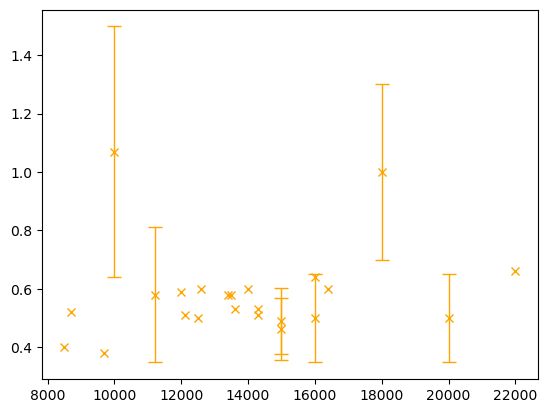

	Points plotted are only original data (without artificial points)


In [182]:
#Select one of the lines with the highest number of entries in full dataset
#Set index "idx"from 0 to ..., where 0 represents the line with the highest number of entries
idx = 4
wavelength = list(data_width['Wavelength'].value_counts().index)[idx]
data_width_train_full, target_width_train_full = data_width_train.copy(), target_width_train.copy()
data_width_elements_full, target_width_elements_full = data_width_elements.copy(), target_width_elements.copy()
data_width_train, target_width_train = data_width.copy(), target_width.copy()

line_data = data.loc[(data_width['Wavelength'] == wavelength) & (data['w (A)'].isna() == False)]
line_data_train = data_width_train[data_width_train['Wavelength'] == wavelength]

# data_width_train, target_width_train = data_width_train.drop(line_data_train.index), target_width_train.drop(line_data_train.index)
data_width_elements   = line_data.drop(columns = ['w (A)', 'd (A)','w error (%)', 'd error (%)'])
target_width_elements = line_data['w (A)']
label_width_elements = line_data['Element']

print(line_data['Element'].iloc[0], line_data['Wavelength'].iloc[0], 'nm;', line_data.shape[0], 'data points;', ' ',
     data_width_train[data_width_train['Wavelength'] == wavelength].shape[0], 'points in train')

T_low, T_high = line_data['T'].describe()['min'], line_data['T'].describe()['max']
print(f'Data from {T_low}K to {T_high} available for this line')

fig, ax = plt.subplots()
ax.plot(line_data['T'], line_data['w (A)'], color = 'orange', ls = 'None', marker = 'x')
ax.errorbar(line_data.loc[line_data['w error (%)'].isna() == False]['T'],
           line_data.loc[line_data['w error (%)'].isna() == False]['w (A)'],
           yerr = line_data.loc[line_data['w error (%)'].isna() == False]['w error (%)']/100*line_data.loc[line_data['w error (%)'].isna() == False]['w (A)'],
           color = 'orange', ls = 'None', capsize=5, lw = 1)

plt.show()

print(f'\tPoints plotted are only original data (without artificial points)')

In [183]:
#Define temperature range in each case
T_low, T_high = line_data['T'].describe()['min'], line_data['T'].describe()['max']

npoints = int((T_high - T_low)//500)
temperatures = np.linspace(T_low, T_high, npoints)

unit = line_data[line_data['Wavelength'].duplicated() == False]

for i in range(npoints):
    unit['T'] = temperatures[i]
    if i == 0:
        temperature_test_data = unit.copy()
    else:
        temperature_test_data = pd.concat([temperature_test_data, unit])

temperature_test_data = temperature_test_data.drop(columns=['w (A)', 'd (A)',
                                                            'w error (%)', 'd error (%)'])

C:\Users\Alex\AppData\Local\Temp\4\ipykernel_7032\2323132408.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unit['T'] = temperatures[i]


In [184]:
data_width_test_full, target_width_test_full = data_width_test.copy(), target_width_test.copy()
data_width_test, target_width_test = temperature_test_data.reset_index(drop = True), temperature_test_data['1s'].reset_index(drop = True)

In [185]:
models = [
    ['XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No', 'LightGBM_A+I_Enorm_Raw_Scaler', 'LightGBM_A+I_Eraw_Raw_No', 'XGB_A+I_Enorm_Aug_No'],
    ['XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No', 'LightGBM_A+I_Enorm_Raw_Scaler', 'LightGBM_A+I_Eraw_Raw_No', 'XGB_A+I_Enorm_Aug_No', 'CatBoost_A+I_Eraw_Raw_No'],
    ['XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No'],
    ['LightGBM_A+I_Eraw_Raw_Scaler'],
    ['XGB_A+I_Eraw_Raw_No']
        ]
glob_path = 'C:\\Users\\Alex\\Documents\\GitHub'

models_d     = {}
preds_d      = []
preds_elem_d = []

for ensemble in tqdm(models):
    preds_ensemble      = {}
    preds_elem_ensemble = {}
    for item in ensemble:
        if '_A+I_' in item:
            parameter = 'width'
        elif '_Shift_' in item:
            parameter = 'shift'
        else:
            raise NameError(f"Parameter for prediction must be specified in model's name: {item}")

        if 'KNN' in item:
            path = glob_path + '\\KNN'
        elif 'RF' in item:
            path = glob_path + '\\RF'
        elif 'XGB' in item:
            path = glob_path + '\\XGB'
        elif 'LightGBM' in item:
            path = glob_path + '\\LightGBM'
        elif 'CatBoost' in item:
            path = glob_path + '\\CatBoost'

        models_d_item = create_models_dict([item], path = path)

        if '_Eraw_' in item:
            normalized_energy = False
        elif '_Enorm' in item:
            normalized_energy = True

        if '_Raw_' in item:
            augmented_train_set = False
        elif '_Aug_' in item:
            augmented_train_set = True

        if '_No' in item:
            apply_scaler = False
        elif '_Scaler' in item:
            apply_scaler = True

        X_train, Y_train, X_test, Y_test, X_elem, Y_elem, L_elem, scaler = constr_train_test(parameter,
                                                                                             augmented_train_set,
                                                                                             scaled_target=True,
                                                                                             normalized_energy = normalized_energy,
                                                                                             print_stats = False)
        if apply_scaler:
            preds, preds_elem = plot_model_prediction(models_d_item,
                                                      scaler.transform(X_train), Y_train,
                                                      scaler.transform(X_test), Y_test,
                                                      scaler.transform(X_elem), Y_elem, L_elem, 
                                                      plot = False)
        else:
            preds, preds_elem = plot_model_prediction(models_d_item,
                                                      X_train, Y_train,
                                                      X_test, Y_test,
                                                      X_elem, Y_elem, L_elem, 
                                                      plot = False)
        preds_ensemble = preds_ensemble | preds
        preds_elem_ensemble = preds_elem_ensemble | preds_elem
    
    pred = np.zeros(preds_ensemble[ensemble[0]].shape)
    pred_elem = np.zeros(preds_elem_ensemble[ensemble[0]].shape)
    for key in preds_ensemble.keys():
        pred += preds_ensemble[key]
        pred_elem += preds_elem_ensemble[key]
    pred /= len(preds_ensemble.keys())
    pred_elem /= len(preds_elem_ensemble.keys())
    
    preds_d.append(pred)
    preds_elem_d.append(pred_elem)

data_width_train, target_width_train = data_width_train_full.copy(), target_width_train_full.copy()
data_width_test, target_width_test   = data_width_test_full.copy(), target_width_test_full.copy()
data_width_elements, target_width_elements = data_width_elements_full.copy(), target_width_elements_full.copy()

100%|██████████| 5/5 [03:09<00:00, 37.95s/it]


In [186]:
RMSE_Temperature = []
for i in preds_elem_d:
    RMSE_Temperature.append(root_mean_squared_error(unscale(i), unscale(Y_elem)))

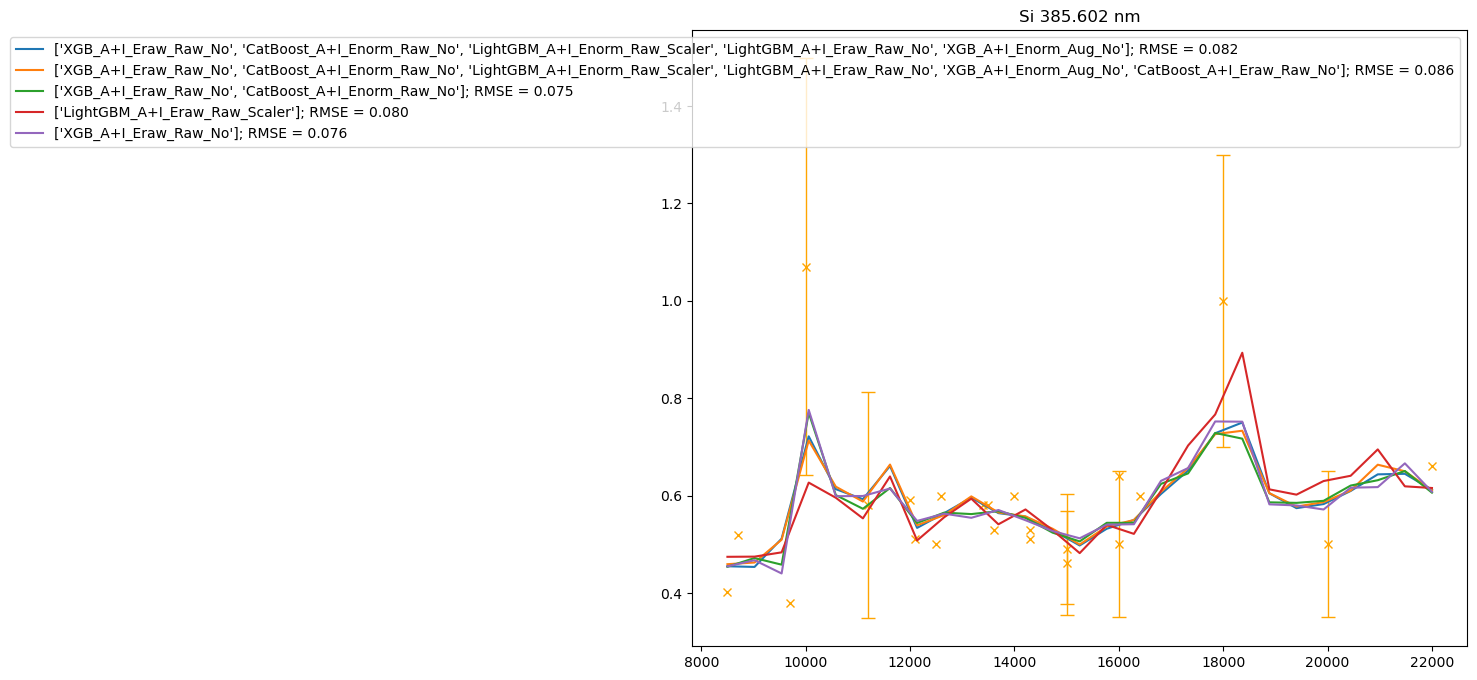

In [187]:
fig, ax = plt.subplots(figsize = (10, 8))
ax.plot(line_data['T'], line_data['w (A)'], color = 'orange', ls = 'None', marker = 'x')
ax.errorbar(line_data.loc[line_data['w error (%)'].isna() == False]['T'],
           line_data.loc[line_data['w error (%)'].isna() == False]['w (A)'],
           yerr = line_data.loc[line_data['w error (%)'].isna() == False]['w error (%)']/100*line_data.loc[line_data['w error (%)'].isna() == False]['w (A)'],
           color = 'orange', ls = 'None', capsize=5, lw = 1)
for i in range(len(models)):
    ax.plot(temperatures, unscale(preds_d[i]), label = str(models[i]) + '; RMSE = ' + str(f'{RMSE_Temperature[i]:.3f}'))

ax.legend()
ax.set_title(f"{line_data['Element'].iloc[0]} {line_data['Wavelength'].iloc[0]} nm")
# ax.set_ylim(-0.02, 0.5)
plt.show()

# Pedicting Stark parameters

In [ ]:
factor = 1.05
data_width_extended = data_width
target_width_extended = target_width
for index, row in data_width.iterrows():
    row['T'] = row['T']*factor
    data_width_extended = data_width_extended.append(row, ignore_index=True, verify_integrity = True)
    target_width_extended = target_width_extended.append(pd.Series(target_width.loc[index]), ignore_index=True)

    row['T'] = row['T']/factor**2
    data_width_extended = data_width_extended.append(row, ignore_index=True, verify_integrity = True)
    target_width_extended = target_width_extended.append(pd.Series(target_width.loc[index]), ignore_index=True)

In [ ]:
models = ['KNN_Extended', 'XGB_Extended', 'TabNet_Extended']
models_d = create_models_dict(models)
epsilon = 1e-3

for name, model in models_d.items():
    print(f"Training {name} model")
    if 'TabNet' in name:
        model.fit(data_width_extended.drop(columns=['Element', 'Wavelength', 'Z number']), np.log(1 + target_width_extended / epsilon), XW_test, np.log(1 + YW_test / epsilon))
    else:
        model.fit(data_width_extended.drop(columns=['Element', 'Wavelength', 'Z number']), np.log(1 + target_width_extended / epsilon))

In [ ]:
data_predictions = pd.read_excel('/content/Stark_ML/Source_files/Stark_data.xlsx',
                     sheet_name='Fe_diagnostics',
                     usecols='A:BC'
                   )
data_predictions['Term'] = term_to_number(data_predictions['Term'])
data_predictions['Term.1'] = term_to_number(data_predictions['Term.1'])

In [ ]:
predictions = {}
for name, model in models_d.items():
    predictions[name] = model.predict(data_predictions.drop(columns=['Element', 'Wavelength', 'Z number', 'w (A)', 'd (A)']))

In [ ]:
fig, ax = plt.subplots()
for name, model in predictions.items():
    ax.plot((np.exp(model) - 1) * epsilon, label = f'{name}')

plt.legend()
plt.show()

In [ ]:
predictions['XGB_Extended']

np.savetxt('Fe predictions.csv', (np.exp(predictions['XGB_Extended']) - 1) * epsilon, delimiter = ',')

In [ ]:
data_width_extended.describe()

# Auxilary functions

In [ ]:
d = pd.read_excel('/content/Stark_ML/Source_files/Stark_data.xlsx',
                     sheet_name='Fe_diagnostics',
                     usecols='BD:BE'
                   )

In [ ]:
with open("insert.txt", "w") as output:
    output.write('insert into starknew (line_id, temp, e_dens, fwhm, alpha, beta, width_ref, shift_ref) \nvalues')
    for index, item in d.iterrows():
        if not np.isnan(item['fwhm']):
            line = f"({item['line_id']}, 7200, 1.0E17, {item['fwhm']}, 0, 0, 19, 19),\n"
            output.write(line)

In [ ]:
with open("delete.txt", "w") as output:
    output.write('delete from starknew where line_id in (')
    for index, item in d.iterrows():
        line = f"{int(item['line_id'])}, "
        output.write(line)
    output.write(')')

# Debugging

In [ ]:
import sklearn
import sklearn.datasets
from sklearn.model_selection import train_test_split

calif_housing = sklearn.datasets.fetch_california_housing()
x = calif_housing.data
y = calif_housing.target
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
x_learn, x_valid, y_learn, y_valid = train_test_split(x_train, y_train, random_state=42)

In [ ]:
from pytorch_tabnet.tab_model import  TabNetRegressor
from warnings import simplefilter
simplefilter("ignore", category=UserWarning)

tabnet = TabNetRegressor()
tabnet.fit(x_learn, y_learn.reshape(-1, 1),
           eval_set = [(x_valid,  y_valid.reshape(-1, 1))])

In [ ]:
!nvidia-smi

In [ ]:
import datetime
print(datetime.datetime.now())
predictions = {}
for i in range(100):
    models = [f'TabNet_Extended']
    models_d = create_models_dict(models)
    epsilon = 1e-3

    for name, model in models_d.items():
        print(f"Training {name}_{i} model")
        if 'TabNet' in name:
            model.fit(data_width_extended.drop(columns=['Element', 'Wavelength', 'Z number']), np.log(1 + target_width_extended / epsilon), XW_test, np.log(1 + YW_test / epsilon))
        predictions[f'{name}_{i}'] = model.predict(data_predictions.drop(columns=['Element', 'Wavelength', 'Z number', 'w (A)', 'd (A)']))
print(datetime.datetime.now())

In [ ]:
import pickle
with open('100 Predictions.pkl', 'wb') as f:
    pickle.dump(predictions, f)

In [ ]:
from IGTD.Scripts.IGTD_Functions import *

In [ ]:
norm_data = min_max_transform(XW_train.to_numpy())

ranking, corr = generate_feature_distance_ranking(norm_data)

pix = generate_matrix_distance_ranking(5, 10)

In [ ]:
%matplotlib inline
plt.figure(figsize= (12,12))
plt.imshow(ranking)
plt.colorbar()
plt.show()

In [ ]:
index_record, err_record, run_time = IGTD_square_error(ranking, pix[1], file_name = 'Resss', save_folder = 'content')

In [ ]:
table_to_image(norm_data, [5, 10], 'Pearson', 'Euclidean', save_image_size = )

In [ ]:
models = ['TabNet_Scaled']
models_d = create_models_dict(models)

for name, models in models_d.items():
    print(f'Fitting model {name}')
    model.fit(XW_train, YW_train)

type(models_d['TabNet_Scaled'])

In [ ]:
%debug

In [ ]:
LW_elem

In [ ]:
models = ['KNN', 'RF', 'GB', 'XGB', 'TabNet', 'LightGBM']

models_d = create_models_dict(models)

tuned_results = train_and_test_regressor(models_d, XW_train, YW_train, XW_test, YW_test)

plot_model_comparison(tuned_results)

In [ ]:
%debug

In [ ]:
nfolds = 5
#kf = KFold(nfolds, shuffle = True, random_state=7)
kf = KFold(nfolds, shuffle = False)
score_XGB = 0
score_GB = 0

with open(path + f'/GB' + '_optimal_parameters', 'r') as fp:
    GB_params = json.load(fp)
with open(path + f'/XGB' + '_optimal_parameters', 'r') as fp:
    XGB_params = json.load(fp)

for train, test in kf.split(XW_train):
    #print(XW_train.iloc[test, :])
    #print(YW_train.iloc[test])
    #break

    model_XGB = xgboost.XGBRegressor(**XGB_params, n_estimators = 500, n_jobs = -1)
    model_GB = GradientBoostingRegressor(**GB_params, n_estimators = 500)
    
    model_XGB.fit(XW_train.iloc[train, :], YW_train.iloc[train])
    model_GB.fit(XW_train.iloc[train, :], YW_train.iloc[train])
    
    score_XGB += mean_squared_error(YW_train.iloc[test], model_XGB.predict(XW_train.iloc[test, :]),
                                squared = True)
    score_GB += mean_squared_error(YW_train.iloc[test], model_GB.predict(XW_train.iloc[test, :]),
                                squared = True)
    print('\n', 'XGB model:', mean_squared_error(YW_train.iloc[test], model_XGB.predict(XW_train.iloc[test, :]),
                                squared = True))
    print('GB model', mean_squared_error(YW_train.iloc[test], model_GB.predict(XW_train.iloc[test, :]),
                                squared = True))
score_XGB /= nfolds
score_GB /= nfolds

print(f"\n XGB score {score_XGB}")
print(f"GB score {score_GB}")

models = {
    'GB' : model_GB,
    'XGB' : model_XGB
}
print(models)
rrr = train_and_test_regressor(models,
                               XW_train,
                               YW_train,
                               XW_test.sample(frac = 1, random_state = 777),
                               YW_test.sample(frac = 1, random_state = 777))
plot_model_comparison(rrr)

fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].plot(YW_test, model_GB.predict(XW_test), 'r.')
ax[1].plot(YW_test, model_XGB.predict(XW_test), 'r.')
for i in ax:
    i.plot([0, 170], [0, 170], color = 'b', ls = '--')
    i.set_xlim(-1, 15)
    i.set_ylim(-1, 15)
plt.show()


print(f'GB MSE: {mean_squared_error(YW_test, model_GB.predict(XW_test))}')
print(f'XGB MSE: {mean_squared_error(YW_test, model_XGB.predict(XW_test))}')


In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].plot(YW_test, model_GB.predict(XW_test), 'r.')
ax[1].plot(YW_test, model_XGB.predict(XW_test), 'r.')
for i in ax:
    i.plot([0, 170], [0, 170], color = 'b', ls = '--')
    i.set_xlim(-1, 5)
    i.set_ylim(-1, 5)
plt.show()

In [ ]:
models = ['KNN', 'RF', 'GB', 'XGB', 'TabNet']

models_d = create_models_dict(models)

In [ ]:
print(models_d.items())

In [ ]:
abc = np.array([2, 3, 4])
abc = abc.flatten()
abc.shape